<a target="_blank" href="https://colab.research.google.com/github/Bo-Ni/ProteinMechanicsDiffusionDesign_pLDM/blob/main/notebook_for_colab/pLDM_inferring_standalong_colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 0. Preparation:
### 0-1. Add packages

In [1]:
#@title ####For omegafold

import os,sys
import math

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #turn off CUDA if needed
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# control the version of torch
# import torch
# if torch.__version__!='1.12.0+cu113':
#   comm_line=f'pip uninstall -y torch torchvision torchaudio torchdata torchtext fastai'
#   print(os.popen(comm_line).read())
#   comm_line=f'pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113'
#   print(os.popen(comm_line).read())

comm_line=f'pip uninstall -y torch torchvision torchaudio torchdata torchtext fastai'
print(os.popen(comm_line).read())
comm_line=f'pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113'
print(os.popen(comm_line).read())
import torch
print('Torch version: ', torch.__version__)

#
# !pip uninstall -y torch torchvision torchaudio torchdata torchtext fastai
# !pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113

path_1 = '/opt/bin/'
dssp_file = path_1+'mkdssp'

file_exists = os.path.exists(dssp_file)
if not (file_exists):
  print('\033[1;32m For the 1st run, ')
  # ==============================================
  print('a. Install omegafold...')
  # install omegafold
  # ref: https://github.com/HeliXonProtein/OmegaFold
  !pip install git+https://github.com/HeliXonProtein/OmegaFold.git
  # add some fix for compability problems
  !pip install torchvision==0.13.0+cu113

  # time-consuming step:
  # Downloading weights from https://helixon.s3.amazonaws.com/release1.pt to /root/.cache/omegafold_ckpt/model.pt
  !mkdir /root/.cache/omegafold_ckpt
  !wget https://helixon.s3.amazonaws.com/release1.pt -O /root/.cache/omegafold_ckpt/model.pt

  print('b. Install DSSP...')
  # download an mkdssp
  # ==============================================
  # download things
  print(os.popen(f"wget https://www.dropbox.com/s/v4azy9z9yojg1c6/mkdssp -P {path_1}").read())
  #
  !chmod u+x /opt/bin/mkdssp

else:
  print('This is not the first run... ')

Found existing installation: torch 2.1.0+cu121
Uninstalling torch-2.1.0+cu121:
  Successfully uninstalled torch-2.1.0+cu121
Found existing installation: torchvision 0.16.0+cu121
Uninstalling torchvision-0.16.0+cu121:
  Successfully uninstalled torchvision-0.16.0+cu121
Found existing installation: torchaudio 2.1.0+cu121
Uninstalling torchaudio-2.1.0+cu121:
  Successfully uninstalled torchaudio-2.1.0+cu121
Found existing installation: torchdata 0.7.0
Uninstalling torchdata-0.7.0:
  Successfully uninstalled torchdata-0.7.0
Found existing installation: torchtext 0.16.0
Uninstalling torchtext-0.16.0:
  Successfully uninstalled torchtext-0.16.0
Found existing installation: fastai 2.7.13
Uninstalling fastai-2.7.13:
  Successfully uninstalled fastai-2.7.13

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 67.3 MB/s eta 0:00:

In [2]:
#@title ####For other pip packages
# add some packages
try:
  print('\033[1;32m a. on Biopython...')
  from Bio.PDB import PDBParser
except ImportError as e:
  print(os.popen('pip install biopython').read())

try:
  print('\033[1;32m b. on kornia...')
  import kornia.augmentation
except ImportError as e:
  print(os.popen('pip install kornia').read())

try:
  print('\033[1;32m c. on einops...')
  from einops import rearrange, repeat, reduce
except ImportError as e:
  print(os.popen('pip install einops').read())

try:
  from einops_exts import rearrange_many, repeat_many, check_shape
except ImportError as e:
  print(os.popen('pip install einops-exts').read())

try:
  import pytorch_warmup as warmup
except ImportError as e:
  print(os.popen('pip install pytorch-warmup').read())

try:
  from ema_pytorch import EMA
except ImportError as e:
  print(os.popen('pip install ema-pytorch').read())

try:
  from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs
except ImportError as e:
  print(os.popen('pip install accelerate').read())

try:
  import py3Dmol
except ImportError as e:
  print(os.popen('pip install py3Dmol').read())

# added
try:
  import esm
except ImportError as e:
  print(os.popen('pip install fair-esm').read())

try:
  import torchinfo
except ImportError as e:
  print(os.popen('pip install torchinfo').read())

 a. on Biopython...
 b. on kornia...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 8.5 MB/s eta 0:00:00

 c. on einops...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 10.7 MB/s eta 0:00:00

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.1 MB/s eta 0:00:00




### 0.2. copy src from github

In [3]:
#@title #### Model code

import json, time, os, sys, glob

# # just script, no install is used
# if not os.path.isdir("ProteinMPNN"):
#   os.system("git clone -q https://github.com/dauparas/ProteinMPNN.git")
# sys.path.append('/content/ProteinMPNN/')

# ===================================================================

if not os.path.isdir("ProteinMechanicsDiffusionDesign_pLDM"):
  os.system("git clone -q https://github.com/Bo-Ni/ProteinMechanicsDiffusionDesign_pLDM.git")
# sys.path.append('/content/ProteinMechanicsDiffusionDesign_pLDM/ProteinMechanicsDiffusionDesign/')
sys.path.append('/content/ProteinMechanicsDiffusionDesign_pLDM/')

In [4]:
#@title #### Small test
# a slient test
# import ProteinMechanicsDiffusionDesign.UtilityPack as UtilityPack
# import ProteinMechanicsDiffusionDesign.DataSetPack as DataSetPack
# import ProteinMechanicsDiffusionDesign.ModelPack as ModelPack
# import ProteinMechanicsDiffusionDesign.TrainerPack as TrainerPack
# import ProteinMechanicsDiffusionDesign.PostMDPack as PostMDPack
#
import PD_pLMProbXDiff.UtilityPack as UtilityPack
import PD_pLMProbXDiff.DataSetPack as DataSetPack
import PD_pLMProbXDiff.ModelPack as ModelPack
import PD_pLMProbXDiff.TrainerPack as TrainerPack
import PD_pLMProbXDiff.PostMDPack as PostMDPack

identify the device independently cuda:0


### 0.3. Download the model files

In [5]:
#@title #### Set up the saved model

# just script, no install is used
this_working_path = '/content/working_results/'

if not os.path.isdir(this_working_path):
  print('Creating working path...')
  print(os.popen('mkdir '+this_working_path).read())
  print('Done.')
  print('Downing files...')

this_file = this_working_path+'model_pack.pickle'
file_exists = os.path.exists(this_file)
if not (file_exists):
  # download things
  this_link='https://www.dropbox.com/scl/fi/i2sull7ftjwrrzeaxo8v1/model_pack.pickle?rlkey=7wy5zynrl6m8azufklq3fy8ql&dl=0'
  cmd_line = f"wget -O {this_file} {this_link}"
  print(os.popen(cmd_line).read())

#
this_file = this_working_path+'data_pack.pickle'
file_exists = os.path.exists(this_file)
if not (file_exists):
  # download things
  this_link='https://www.dropbox.com/scl/fi/z7sz0q2nsjn85kyh68p86/data_pack.pickle?rlkey=bwm9fgf29ze8o516r155zg4gl&dl=0'
  cmd_line = f"wget -O {this_file} {this_link}"
  print(os.popen(cmd_line).read())

# add for dataset part
this_temp_path = this_working_path+'0_dataprocess_MD/'
if not os.path.isdir(this_temp_path):
  print('Creating data path...')
  print(os.popen('mkdir '+this_temp_path).read())
  print('Done.')
  print('Downing files...')
# add file if needed
#
this_file = this_working_path+'0_dataprocess_MD/'+'ForTest_LE_128_From_F1_f5.pt'
file_exists = os.path.exists(this_file)
if not (file_exists):
  # download things
  this_link='https://www.dropbox.com/scl/fi/zn2qdcdd4apsh88xirfzj/ForTest_LE_128_From_F1_f5.pk?rlkey=oamepqanqbpzrt8lrgjknp9bk&dl=0'
  cmd_line = f"wget -O {this_file} {this_link}"
  print(os.popen(cmd_line).read())

# add for model part
this_temp_path = this_working_path+'1_model_SS/'
if not os.path.isdir(this_temp_path):
  print('Creating model path...')
  print(os.popen('mkdir '+this_temp_path).read())
  print('Done.')
  print('Downing files...')
# add file if needed
#
this_file = this_working_path+'1_model_SS/'+'trainer_save-model_pLDM.pt'
file_exists = os.path.exists(this_file)
if not (file_exists):
  # download things
  this_link='https://www.dropbox.com/s/09wyap14yrnoeom/trainer_save-model_pLDM.pt?dl=0'
  cmd_line = f"wget -O {this_file} {this_link}"
  print(os.popen(cmd_line).read())

Creating working path...

Done.
Downing files...


Creating data path...

Done.
Downing files...

Creating model path...

Done.
Downing files...



## 1. Working part

In [6]:
#@title ### 1.0. Check the floor
import os, sys
print('Here is : \n', os.popen('pwd').read())
print('What we get in hardware: \n', os.popen('nvidia-smi').read())

import torch
print("What we have in software: \n Torch version:", torch.__version__)
print('Python: ', sys.version) # no switch case code
print()

import torch
print("What we have in software: \n Torch version:", torch.__version__)
print('Python: ', sys.version) # no switch case code
print()

print('What hardware the software see:')
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
print(device)
num_of_gpus = torch.cuda.device_count()
print("# of GPU", num_of_gpus)
print()
torch.cuda.empty_cache()

Here is : 
 /content

What we get in hardware: 
 Sun Dec 17 13:12:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              25W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+------------------

In [7]:
#@title ### 1.1. Setup the problem
# prepare for package debugging
# for debug
import importlib
import json
import matplotlib.pyplot as plt
# import PD_pLMProbXDiff.UtilityPack as UtilityPack
# # run this when updating the package
# importlib.reload(UtilityPack)
# ===============================================
# Global control key setup
# ===============================================
# Control keys:
# This one will be directly modified for each task
CKeys = dict(
    #
    Running_Type=2, # 1-local:engaging cluster, 2-supercould cluster, 3-google colab, 4-local ubuntu
    #
    # Working_Mode=1, # 1-training, 2-sampling for test
    Working_Mode=2,
    #
    # IF_FirstRun=1,  # 1-1st run of training; otherwise, # of training run
    IF_FirstRun=2,  # 1-1st run of training; otherwise, # of training run
    #
    # 1-SecStr-ModelB, 2-MD-ModelB, 3-SecStr-ModelA, 4-MD-ModelA
    # 5-SecStr-ModelB-Embdding, 6-MD-ModelB, 7-SecStr-ModelA-pLM, 8-MD-ModelA
    # 9-MD-Predictor-ModelB, 10-
    # 11-MD-ModelB
    Problem_ID=11, # 8, # 6,
    #
    # Debug=1, # 1-debug mode on; add more debug keys for different blocks
    Debug=0, # 1-debug mode on; add more debug keys for different blocks
    #
    Debug_DataSet=1,
    Debug_Model=1
    #
    # Debug=0
)

if CKeys['Debug']==1:
    # add some
    CKeys['SlientRun']=0 # 1-save figure into files; 0-show figures
    # detailed debug keys
    # 1. for model dimension
    CKeys['Debug_DataPack']=1
    CKeys['Debug_ModelPack']=1
    CKeys['Debug_TrainerPack']=1
    # 2. for trainer part
    CKeys['Debug_DataPack']=1
    CKeys['Debug_ModelPack']=0
    CKeys['Debug_TrainerPack']=3
    # #
    # CKeys['testratio']=0.15 # for small ForcPath problem
    CKeys['testratio']=0.10 # for large ForcPath problem

else:
    # for real working run
    CKeys['SlientRun']=1
    #
    CKeys['Debug_DataPack'] = 0
    CKeys['Debug_ModelPack'] = 0
    CKeys['Debug_TrainerPack'] = 0 # 2 # 1
    # add some for training
    CKeys['epochs'] = 4000-3250 # 1000 # 200
    CKeys['print_loss_every_this_epochs']=50 # 5
    CKeys['sample_every_this_epochs']=100 # 50 # 20
    CKeys['save_model_every_this_epochs']=50 # 20
    # #
    # # add some for training
    # CKeys['epochs'] = 2000 # 1000 # 200
    # CKeys['print_loss_every_this_epochs']=20 # 5
    # CKeys['sample_every_this_epochs']=50 # 50 # 20
    # CKeys['save_model_every_this_epochs']=50 # 20
    #
    # CKeys['testratio']=0.15 # for small ForcPath problem
    CKeys['testratio']=0.10 # for large ForcPath problem
    #
    # # add some for training
    # CKeys['epochs'] = 4 # 1000 # 200
    # CKeys['print_loss_every_this_epochs']=1 # 5
    # CKeys['sample_every_this_epochs']=1 # 50 # 20
    # CKeys['save_model_every_this_epochs']=2 # 20

# for check
print(json.dumps(CKeys, indent=4))


# Problem type:
print('Problem type: ', CKeys['Problem_ID'])
print('Debug mode: ', CKeys['Debug'])
print('Working mode: ', CKeys['Working_Mode'])


# ===========================================================
# Parameter key:
# ===========================================================
#
PKeys = {}
# define this one according the running environment
# add more if needed
# if CKeys['Running_Type']==1 or CKeys['Running_Type']==4:
# if CKeys['Running_Type']==1:
#
#
root_path = '/home/gridsan/bni/Test_ground/jupyter/1_git_project/sort_pdb_database_0/Local_Store/'
if CKeys['Debug']==1:
    # PKeys['prefix']='../Local_Store/For_16_0/'
    # use the absolute path for transformability
    PKeys['prefix']=root_path+'For_20_0/'

if CKeys['Debug']!=1:
    # PKeys['prefix']='../Local_Store/For_16_1/'
    PKeys['prefix']=root_path+'For_20_1/'
    PKeys['prefix']='/home/gridsan/bni/16_WG_git_sort_pdb_database_0/11_pLMProb_Diff_SMD_ModelB_embed_640/0_Training/'
    # add one for google colab
    PKeys['prefix']=this_working_path # '/content/11_pLMProb_Diff_SMD_ModelB_embed_640/0_Training/'

# store the data pack after processing
PKeys['pk_data_pack']=PKeys['prefix']+'data_pack.pickle'
PKeys['pk_model_pack']=PKeys['prefix']+'model_pack.pickle'
# PKeys[]
# print(CKeys['Running_Type'])
# print(CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1)
# print(PKeys['prefix'])

#
# clean EVERYTHING in the dir if 1st
#
if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1:
    if os.path.exists(PKeys['prefix']):
        cmd_line=f"rm -r {PKeys['prefix']}"
        print("clean the slade...")
        print(f"excute {cmd_line}")
        os.popen(cmd_line).read()
        #
    # create dir for working space
    UtilityPack.create_path(PKeys['prefix'])
# ========================================================================
# prepare the csv files
# ========================================================================

if CKeys['Problem_ID']==1 or CKeys['Problem_ID']==3 \
or CKeys['Problem_ID']==5 or CKeys['Problem_ID']==7:
#     SS_csv_file = PKeys['prefix']+'PROTEIN_Mar18_2022_SECSTR_ALL.csv'

#     file_exists = os.path.exists(SS_csv_file)
#     if not (file_exists):
#         print('Downing the csv file...')
#         print(os.popen(f"wget https://www.dropbox.com/s/7o7s15w9qr6z76y/PROTEIN_Mar18_2022_SECSTR_ALL.csv -P {PKeys['prefix']}").read())
#         print('Done.')
#     else:
#         print("Already there")
    # +
    # SS_csv_file = '/home/gridsan/bni/Test_ground/jupyter/1_git_project/sort_pdb_database_0/Local_Store/'+'PROTEIN_Mar18_2022_SECSTR_ALL.csv'
    SS_csv_file = root_path+'Local_Store/'+'PROTEIN_Mar18_2022_SECSTR_ALL.csv'

if CKeys['Problem_ID']==2 or CKeys['Problem_ID']==4 \
or CKeys['Problem_ID']==6 or CKeys['Problem_ID']==8 \
or CKeys['Problem_ID']==11:
    # to be copied locally
    # MD_smo_csv_file = '/home/gridsan/bni/Test_ground/jupyter/1_git_project/sort_pdb_database_0/Local_Store/For_1/ForTrain_recon_BSDB_LE_64_smd_disp_forc_df_smo.csv'
    # first debug with LE_64, to be update into LE_128
    MD_smo_csv_file = root_path+'For_1/ForTrain_recon_BSDB_LE_64_smd_disp_forc_df_smo.csv'
    MD_smo_pk_file  = root_path+'For_1/ForTrain_recon_BSDB_LE_64_smd_disp_forc_df_smo_shared.pk'
    # into LE_128
    MD_smo_pk_file  = root_path+'For_1/ForTrain_recon_BSDB_LE_128_smd_disp_forc_df_smo.pk'

{
    "Running_Type": 2,
    "Working_Mode": 2,
    "IF_FirstRun": 2,
    "Problem_ID": 11,
    "Debug": 0,
    "Debug_DataSet": 1,
    "Debug_Model": 1,
    "SlientRun": 1,
    "Debug_DataPack": 0,
    "Debug_ModelPack": 0,
    "Debug_TrainerPack": 0,
    "epochs": 750,
    "print_loss_every_this_epochs": 50,
    "sample_every_this_epochs": 100,
    "save_model_every_this_epochs": 50,
    "testratio": 0.1
}
Problem type:  11
Debug mode:  0
Working mode:  2


In [8]:
#@title ### 1.2. Handle the dataset

import pickle
import numpy as np
import pandas as pd
# import PD_pLMProbXDiff.DataSetPack as DataSetPack
# importlib.reload(DataSetPack)
print('On Problem: ', CKeys['Problem_ID'])
print(this_working_path)
# on the sec_str csv file: SecStr
# try to convey all para via one key
# ====================================================
# add some new keys for dataset
# ====================================================
# for data washing: only for 1st training cycle
if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1:

    if CKeys['Problem_ID']==1:
        pass
        # print("1")
        # # +++++++++++++++++++++++++++++++++++++
        # # SecStr as input seq
        # DataKeys={}
        # DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_SS/'
        # # screening rules
        # DataKeys['min_AA_seq_len']=0
        # DataKeys['max_AA_seq_len']=128
        # # X and Y processing
        # DataKeys['Xnormfac']=9.
        # DataKeys['ynormfac']=21.
        # DataKeys['tokenizer_X']=None
        # DataKeys['tokenizer_y']=None
        # # + for AA embending using ESM
        # DataKeys['ESM-2_Model']='esm2_t33_650M_UR50D'
        # # deliver
        # DataKeys['batch_size']=256
        # DataKeys['batch_size']=200
        # DataKeys['testset_ratio']=0.1
        # DataKeys['maxdata']=99999999999999999
        # # add the folder for Data part
        # UtilityPack.create_path(DataKeys['data_dir'])

    elif CKeys['Problem_ID']==2:
        pass
        print("2")
#         # ++++++++++++++++++++++++++++++++++++++
#         # MD record as the input seq
#         #
#         # try to convey all para via one key
#         DataKeys={}
#         # ======================================
#         # keys for "screen_dataset_MD"
#         DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_MD/'
#         # add the folder
#         UtilityPack.create_path(DataKeys['data_dir'])

#         # screening rules
#         DataKeys['min_AA_seq_len']=0
#         DataKeys['max_AA_seq_len']=64
#         DataKeys['max_Force_cap']=1000
#         # special ones
#         # change text arr into np arr
#         DataKeys['arr_key']=[
#             'posi_data','pull_data','forc_data',
#             'gap_data','normalized_gap_data',
#             'pull_gap_data', 'normalized_pull_gap_data',
#             'sample_NormPullGap_data','sample_FORCEpN_data']

#         df_raw, protein_df = DataSetPack.screen_dataset_MD(
#             file_path=MD_smo_csv_file,
#             PKeys=DataKeys, # to be updated
#             CKeys=CKeys,
#         )

#         # save the dataframe
#         pd.to_pickle(protein_df, DataKeys['data_dir']+'protein_df.pk')
#         pd.to_pickle(df_raw, DataKeys['data_dir']+'df_raw.pk')

#         # ======================================
#         # keys for 2nd function
#         DataKeys['X_Key']='sample_FORCEpN_data' # or 'Max_Smo_Force'
#         #
#         DataKeys['tokenizer_X']=None # will not be used
#         DataKeys['tokenizer_y']=None # to be created
#         DataKeys['Xnormfac'] = np.max(protein_df['Max_Smo_Force'])
#         print('Normalization factor for force: ', DataKeys['Xnormfac'])
#         DataKeys['ynormfac']=21. # old force diffusion model 22.
#         #
#         DataKeys['batch_size']=256
#         DataKeys['testset_ratio']=0.15
#         DataKeys['maxdata']=99999999991000

    elif CKeys['Problem_ID']==3:
        pass
        # print("3")
        # # +++++++++++++++++++++++++++++++++++++
        # # SecStr as input seq
        # DataKeys={}
        # DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_SS_ModelA/'
        # # screening rules
        # DataKeys['min_AA_seq_len']=0
        # DataKeys['max_AA_seq_len']=64 # 128
        # DataKeys['max_text_len']=8
        # # X and Y processing
        # DataKeys['Xnormfac']=1.
        # DataKeys['ynormfac']=22. # 21.
        # DataKeys['tokenizer_X']=None
        # DataKeys['tokenizer_y']=None
        # # deliver
        # DataKeys['batch_size']=512
        # # for debug purpose
        # # DataKeys['batch_size']=1
        # DataKeys['testset_ratio']= 0.1
        # DataKeys['maxdata']=99999999999999999
        # # add the folder for Data part
        # UtilityPack.create_path(DataKeys['data_dir'])

    elif CKeys['Problem_ID']==4:
        pass

#         print("4: input text condition, output sequence...")
#         # ++++++++++++++++++++++++++++++++++++++
#         # MD record as the input seq
#         #
#         # try to convey all para via one key
#         DataKeys={}
#         # ======================================
#         # keys for "screen_dataset_MD"
#         DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_MD/'
#         # add the folder
#         UtilityPack.create_path(DataKeys['data_dir'])

#         # screening rules
#         DataKeys['min_AA_seq_len']=0
#         DataKeys['max_AA_seq_len']=64
#         DataKeys['max_text_len']=2
#         DataKeys['max_Force_cap']=1000
#         # special ones
#         # change text arr into np arr
#         DataKeys['arr_key']=[
#             'posi_data','pull_data','forc_data',
#             'gap_data','normalized_gap_data',
#             'pull_gap_data', 'normalized_pull_gap_data',
#             'sample_NormPullGap_data','sample_FORCEpN_data']

#         df_raw, protein_df = DataSetPack.screen_dataset_MD(
#             file_path=MD_smo_csv_file,
#             PKeys=DataKeys, # to be updated
#             CKeys=CKeys,
#         )

#         # save the dataframe
#         pd.to_pickle(protein_df, DataKeys['data_dir']+'protein_df.pk')
#         pd.to_pickle(df_raw, DataKeys['data_dir']+'df_raw.pk')

#         # ======================================
#         # keys for 2nd function
#         DataKeys['X_Key']=['Max_Smo_Force','Int_Smo_ForcPull'] # 'sample_FORCEpN_data' # or 'Max_Smo_Force'
#         #
#         DataKeys['tokenizer_X']=None # will not be used
#         DataKeys['tokenizer_y']=None # to be created
#         #
#         print('Normalization factor for force: ',
#               np.max(protein_df['Max_Smo_Force']))
#         print('Normalization factor for toughness: ',
#               np.max(protein_df['Int_Smo_ForcPull']))
#         #
#         DataKeys['Xnormfac'] = np.array([
#             np.max(protein_df['Max_Smo_Force']),
#             np.max(protein_df['Int_Smo_ForcPull'])
#         ])
#         #
#         DataKeys['ynormfac']=21. # old force diffusion model 22.
#         #
#         DataKeys['batch_size']=256
#         DataKeys['testset_ratio']=0.15
#         DataKeys['maxdata']=99999999991000

    # /////////////////////////////////////////////////////////////
    # try embedding
    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    elif CKeys['Problem_ID']==5:
        pass

#         print("5")
#         # +++++++++++++++++++++++++++++++++++++
#         # SecStr as input seq
#         DataKeys={}
#         DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_SS/'
#         # screening rules
#         DataKeys['min_AA_seq_len']=0
#         DataKeys['max_AA_seq_len']=128
#         # X and Y processing
#         DataKeys['Xnormfac']=9.
#         DataKeys['ynormfac']=1 # for ESM # 21.
#         DataKeys['tokenizer_X']=None
#         DataKeys['tokenizer_y']=None
#         # + for AA embending using ESM
#         DataKeys['ESM-2_Model']='esm2_t33_650M_UR50D'
#         # add for embedding space
#         DataKeys['image_channels']=1280
#         # deliver
#         DataKeys['batch_size']=256
#         DataKeys['batch_size']=256 # 0 # 200
#         DataKeys['testset_ratio']=CKeys['testratio'] # 0.1
#         DataKeys['maxdata']=99999999999999999

#         # add the folder for Data part
#         UtilityPack.create_path(DataKeys['data_dir'])
    #
    elif CKeys['Problem_ID']==6:
        print("6, input MD ForcePath, output AA sequence")
        # ++++++++++++++++++++++++++++++++++++++
        # MD record as the tokenized input seq
        #
        # try to convey all para via one key
        DataKeys={}
        # ======================================
        # keys for "screen_dataset_MD"
        DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_MD/'
        # add the folder
        UtilityPack.create_path(DataKeys['data_dir'])

        # screening rules
        DataKeys['min_AA_seq_len']=0
        # DataKeys['max_AA_seq_len']=64
        DataKeys['max_AA_seq_len']=128
        DataKeys['max_Force_cap']=1000
#         # ---------------------------------------
#         # special ones
#         # change text arr into np arr
#         DataKeys['arr_key']=[
#             'posi_data','pull_data','forc_data',
#             'gap_data','normalized_gap_data',
#             'pull_gap_data', 'normalized_pull_gap_data',
#             'sample_NormPullGap_data','sample_FORCEpN_data']

#         df_raw, protein_df = DataSetPack.screen_dataset_MD(
#             csv_file=MD_smo_csv_file,
#             pk_file=None,
#             PKeys=DataKeys, # to be updated
#             CKeys=CKeys,
#         )
        # ++++++++++++++++++++++++++++++++++++++
        df_raw, protein_df = DataSetPack.screen_dataset_MD(
            csv_file=None,
            pk_file=MD_smo_pk_file,
            PKeys=DataKeys, # to be updated
            CKeys=CKeys,
        )

        # save the dataframe
        pd.to_pickle(protein_df, DataKeys['data_dir']+'protein_df.pk')
        pd.to_pickle(df_raw, DataKeys['data_dir']+'df_raw.pk')

        # ======================================
        # keys for 2nd function
        DataKeys['X_Key']='sample_FORCEpN_data' # or 'Max_Smo_Force'
        #
        DataKeys['tokenizer_X']=None # will not be used
        DataKeys['tokenizer_y']=None # to be created
        # think about this: update this one if necessary
        # DataKeys['Xnormfac'] = np.max(protein_df['Max_Smo_Force'])
        DataKeys['Xnormfac'] = 750.

        print('Normalization factor for force: ', DataKeys['Xnormfac'])
        DataKeys['ynormfac']=1. # not used as esm is used # 21. # old force diffusion model 22.
        #
        DataKeys['batch_size']=256
        DataKeys['testset_ratio']=0.15
        DataKeys['maxdata']=99999999991000
        # ++ for pLM
        # for AA embending using ESM
        DataKeys['ESM-2_Model']='esm2_t33_650M_UR50D'
        # add for embedding space
        DataKeys['image_channels']=1280
        #
        DataKeys['ESM-2_Model']='esm2_t12_35M_UR50D'
        DataKeys['image_channels']=480


    elif CKeys['Problem_ID']==7:
        pass
        # print("7")
        # # +++++++++++++++++++++++++++++++++++++
        # # SecStr text as input seq
        # DataKeys={}
        # DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_SS_ModelA/'
        # # screening rules
        # DataKeys['min_AA_seq_len']=0
        # DataKeys['max_AA_seq_len']=64 # 128
        # DataKeys['max_text_len']=8
        # # X and Y processing
        # DataKeys['Xnormfac']=1.
        # DataKeys['ynormfac']=1. # for ESM # 21. 22. # 21.
        # DataKeys['tokenizer_X']=None
        # DataKeys['tokenizer_y']=None
        # # deliver
        # DataKeys['batch_size']=512
        # # for debug purpose
        # # DataKeys['batch_size']=1
        # DataKeys['testset_ratio']= CKeys['testratio'] # 0.1
        # DataKeys['maxdata']=99999999999999999
        # # + for AA embending using ESM
        # DataKeys['ESM-2_Model']='esm2_t33_650M_UR50D'
        # # add for embedding space
        # DataKeys['image_channels']=1280
        # #
        # # add the folder for Data part
        # UtilityPack.create_path(DataKeys['data_dir'])

    elif CKeys['Problem_ID']==8:
        #
        print("8: input text condition, output sequence...")
        # ++++++++++++++++++++++++++++++++++++++
        # MD record as the input seq
        #
        # try to convey all para via one key
        DataKeys={}
        # ======================================
        # keys for "screen_dataset_MD"
        DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_MD/'
        # add the folder
        UtilityPack.create_path(DataKeys['data_dir'])

        # screening rules
        DataKeys['min_AA_seq_len']=0
        DataKeys['max_AA_seq_len']=64
        DataKeys['max_AA_seq_len']=128
        DataKeys['max_text_len']=2
        DataKeys['max_Force_cap']=1000
#         # ---------------------------------------------------------
#         # special ones
#         # change text arr into np arr
#         DataKeys['arr_key']=[
#             'posi_data','pull_data','forc_data',
#             'gap_data','normalized_gap_data',
#             'pull_gap_data', 'normalized_pull_gap_data',
#             'sample_NormPullGap_data','sample_FORCEpN_data']

#         df_raw, protein_df = DataSetPack.screen_dataset_MD(
#             # # --
#             # file_path=MD_smo_csv_file,
#             # ++
#             csv_file=MD_smo_csv_file,
#             pk_file=None,
#             PKeys=DataKeys, # to be updated
#             CKeys=CKeys,
#         )
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        df_raw, protein_df = DataSetPack.screen_dataset_MD(
            csv_file=None,
            pk_file=MD_smo_pk_file,
            PKeys=DataKeys, # to be updated
            CKeys=CKeys,
        )

        # save the dataframe
        pd.to_pickle(protein_df, DataKeys['data_dir']+'protein_df.pk')
        pd.to_pickle(df_raw, DataKeys['data_dir']+'df_raw.pk')

        # ======================================
        # keys for 2nd function
        DataKeys['X_Key']=['Max_Smo_Force','Int_Smo_ForcPull'] # 'sample_FORCEpN_data' # or 'Max_Smo_Force'
        #
        DataKeys['tokenizer_X']=None # will not be used
        DataKeys['tokenizer_y']=None # will not be used # to be created
        #
        print('Normalization factor for force: ',
              np.max(protein_df['Max_Smo_Force']))
        print('Normalization factor for toughness: ',
              np.max(protein_df['Int_Smo_ForcPull']))
        #
        DataKeys['Xnormfac'] = np.array([
            np.max(protein_df['Max_Smo_Force']),
            np.max(protein_df['Int_Smo_ForcPull'])
        ])
        #
        DataKeys['ynormfac']=1.0 # not used in esm # 21. # old force diffusion model 22.
        #
        DataKeys['batch_size']=256
        DataKeys['testset_ratio']=CKeys['testratio'] # 0.15
        DataKeys['maxdata']=99999999991000
        # + for AA embending using ESM
        DataKeys['ESM-2_Model']='esm2_t33_650M_UR50D'
        # add for embedding space
        DataKeys['image_channels']=1280

    elif CKeys['Problem_ID']==11:
        # copied from Problem_ID=6
        #
        print("11, input MD ForcePath, output AA sequence")
        # ++++++++++++++++++++++++++++++++++++++
        # MD record as the tokenized input seq
        #
        # try to convey all para via one key
        DataKeys={}
        # ======================================
        # keys for "screen_dataset_MD"
        DataKeys['data_dir']=PKeys['prefix']+'0_dataprocess_MD/'
        # add the folder
        UtilityPack.create_path(DataKeys['data_dir'])

        # screening rules
        DataKeys['min_AA_seq_len']=0
        # DataKeys['max_AA_seq_len']=64
        DataKeys['max_AA_seq_len']=128
        DataKeys['max_Force_cap']=1000
#         # ---------------------------------------
#         # special ones
#         # change text arr into np arr
#         DataKeys['arr_key']=[
#             'posi_data','pull_data','forc_data',
#             'gap_data','normalized_gap_data',
#             'pull_gap_data', 'normalized_pull_gap_data',
#             'sample_NormPullGap_data','sample_FORCEpN_data']

#         df_raw, protein_df = DataSetPack.screen_dataset_MD(
#             csv_file=MD_smo_csv_file,
#             pk_file=None,
#             PKeys=DataKeys, # to be updated
#             CKeys=CKeys,
#         )
        # ++++++++++++++++++++++++++++++++++++++
        df_raw, protein_df = DataSetPack.screen_dataset_MD(
            csv_file=None,
            pk_file=MD_smo_pk_file,
            PKeys=DataKeys, # to be updated
            CKeys=CKeys,
        )

        # save the dataframe
        pd.to_pickle(protein_df, DataKeys['data_dir']+'protein_df.pk')
        pd.to_pickle(df_raw, DataKeys['data_dir']+'df_raw.pk')

        # ======================================
        # keys for 2nd function
        DataKeys['X_Key']='sample_FORCEpN_data' # or 'Max_Smo_Force'
        #
        DataKeys['tokenizer_X']=None # will not be used
        DataKeys['tokenizer_y']=None # to be created
        # think about this: update this one if necessary
        # DataKeys['Xnormfac'] = np.max(protein_df['Max_Smo_Force'])
        DataKeys['Xnormfac'] = 750.

        print('Normalization factor for force: ', DataKeys['Xnormfac'])
        DataKeys['ynormfac']=1. # not used as esm is used # 21. # old force diffusion model 22.
        #
        DataKeys['batch_size']=256
        DataKeys['testset_ratio']=0.15
        DataKeys['maxdata']=99999999991000
        # ++ for pLM
        # for AA embending using ESM
        DataKeys['ESM-2_Model']='esm2_t33_650M_UR50D'
        # add for embedding space
        # DataKeys['image_channels']=1280
        #
        # DataKeys['ESM-2_Model']='esm2_t12_35M_UR50D'
        # # DataKeys['image_channels']=480
        #
        # DataKeys['ESM-2_Model']='esm2_t36_3B_UR50D'
        # DataKeys['image_channels']=2560
        #
        DataKeys['ESM-2_Model']='esm2_t30_150M_UR50D'
        # DataKeys['image_channels']=640

        # only use the probability part
        DataKeys['image_channels']=33

    else:
        print('No Problem Type found...')
# else:
#     # load back if there is anything generated in the 1st run
#     if CKeys['Problem_ID']==2 or CKeys['Problem_ID']==6:
#         protein_df = pd.read_pickle(DataKeys['data_dir']+'protein_df.pk')
#         df_raw = pd.read_pickle(DataKeys['data_dir']+'df_raw.pk')
print(CKeys)


# ====================================================
# convert into datasets
# ====================================================
if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1:
    if CKeys['Problem_ID']==1:
        pass
        # train_loader, \
        # train_loader_noshuffle, \
        # test_loader, \
        # tokenizer_y, tokenizer_X = DataSetPack.load_data_set_SS_InSeqToOuSeq(
        #     file_path=SS_csv_file,
        #     PKeys=DataKeys, # to be updated
        #     CKeys=CKeys,
        # )

    elif CKeys['Problem_ID']==2:
        pass
        # train_loader, train_loader_noshuffle, \
        # test_loader, tokenizer_y, tokenizer_X = DataSetPack.load_data_set_from_df_SMD(
        #     protein_df,
        #     PKeys=DataKeys, # to be updated
        #     CKeys=CKeys,
        # )

    elif CKeys['Problem_ID']==3:
        pass
        # train_loader, train_loader_noshuffle, \
        # test_loader,tokenizer_y, tokenizer_X = DataSetPack.load_data_set_seq2seq_SecStr_ModelA (
        #     file_path=SS_csv_file, # 'PROTEIN_Mar18_2022_SECSTR_ALL.csv',
        #     PKeys=DataKeys, # to be updated
        #     CKeys=CKeys,
        # )

    elif CKeys['Problem_ID']==4:
        pass
        # train_loader, train_loader_noshuffle, \
        # test_loader,tokenizer_y, tokenizer_X = DataSetPack.load_data_set_text2seq_MD_ModelA (
        #     protein_df,
        #     PKeys=DataKeys, # to be updated
        #     CKeys=CKeys,
        # )

    # ///////////////////////////////////////////////////////////////
    #  add embedding cases
    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    elif CKeys['Problem_ID']==5:
        pass
        # train_loader, \
        # train_loader_noshuffle, \
        # test_loader, \
        # tokenizer_y, \
        # tokenizer_X = DataSetPack.load_data_set_SS_InSeqToOuSeq_pLM(
        #     file_path=SS_csv_file,
        #     PKeys=DataKeys, # to be updated
        #     CKeys=CKeys,
        # )
        # # this will triger the following downloading
        # # Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /home/gridsan/bni/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
        # # excute the following if without internet on the node
        # # 1 $ wget https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt -O  /home/gridsan/bni/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
        # # 2 $ wget https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt -O /home/gridsan/bni/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt

    # add if needed
    elif CKeys['Problem_ID']==6:

        train_loader, \
        train_loader_noshuffle, \
        test_loader, \
        tokenizer_y, \
        tokenizer_X = DataSetPack.load_data_set_from_df_SMD_pLM(
                protein_df,
                PKeys=DataKeys, # to be updated
                CKeys=CKeys,
            )

    elif CKeys['Problem_ID']==7:
        pass
        # train_loader, \
        # train_loader_noshuffle, \
        # test_loader, \
        # tokenizer_y, \
        # tokenizer_X = DataSetPack.load_data_set_seq2seq_SecStr_ModelA_pLM (
        #     file_path=SS_csv_file, # 'PROTEIN_Mar18_2022_SECSTR_ALL.csv',
        #     PKeys=DataKeys, # to be updated
        #     CKeys=CKeys,
        # )

    elif CKeys['Problem_ID']==8:

        train_loader, \
        train_loader_noshuffle, \
        test_loader,\
        tokenizer_y, \
        tokenizer_X = DataSetPack.load_data_set_text2seq_MD_ModelA_pLM (
            protein_df,
            PKeys=DataKeys, # to be updated
            CKeys=CKeys,
        )

    elif CKeys['Problem_ID']==11:

        train_loader, \
        train_loader_noshuffle, \
        test_loader, \
        tokenizer_y, \
        tokenizer_X = DataSetPack.load_data_set_from_df_SMD_pLM(
                protein_df,
                PKeys=DataKeys, # to be updated
                CKeys=CKeys,
            )

    elif CKeys['Problem_ID']==12:
        pass

    else:
        print('No Problem Type found...')

    print("==========================================")
    print("Save the datasets ...")
    print("==========================================")
    # save the dataset for for the 1st run
    data_pack = {}
    data_pack['train_loader']=train_loader
    data_pack['train_loader_noshuffle']=train_loader_noshuffle
    data_pack['test_loader']=test_loader
    data_pack['tokenizer_X']=tokenizer_X
    data_pack['tokenizer_y']=tokenizer_y
    # keys
    data_pack['DataKeys']=DataKeys
    # data_pack['CKeys']=CKeys
    data_pack['PKeys']=PKeys
    with open(PKeys['pk_data_pack'], 'wb') as handle:
        pickle.dump(data_pack, handle, protocol=pickle.HIGHEST_PROTOCOL)

else: # work both for training and testing

    print('This is not the first run')
    print('Load back in the data packages...')
    with open(PKeys['pk_data_pack'], 'rb') as handle:
        data_pack = pickle.load(handle)
    # deliver the results
    train_loader=data_pack['train_loader']
    train_loader_noshuffle=data_pack['train_loader_noshuffle']
    test_loader=data_pack['test_loader']
    tokenizer_X=data_pack['tokenizer_X']
    tokenizer_y=data_pack['tokenizer_y']
    # keys (create or update)
    DataKeys=data_pack['DataKeys']
    # ++ for colab, need to update the path part
    DataKeys['data_dir']=this_working_path+'0_dataprocess_MD/'
    # ++
    # CKeys=data_pack['CKeys']
    PKeys=data_pack['PKeys']
    # ++ for colab, need to update the path part
    PKeys['prefix']=this_working_path
    PKeys['pk_data_pack']=this_working_path+'data_pack.pickle'
    PKeys['pk_model_pack']=this_working_path+'model_pack.pickle'
    # ++
    # add some for specific problem
    if CKeys['Problem_ID']==2 or CKeys['Problem_ID']==6 \
    or CKeys['Problem_ID']==11:
        pass
        # skip
        # protein_df = pd.read_pickle(DataKeys['data_dir']+'protein_df.pk')
        # df_raw = pd.read_pickle(DataKeys['data_dir']+'df_raw.pk')
    print('Done.')


print(DataKeys)
print(this_working_path)

On Problem:  11
/content/working_results/
{'Running_Type': 2, 'Working_Mode': 2, 'IF_FirstRun': 2, 'Problem_ID': 11, 'Debug': 0, 'Debug_DataSet': 1, 'Debug_Model': 1, 'SlientRun': 1, 'Debug_DataPack': 0, 'Debug_ModelPack': 0, 'Debug_TrainerPack': 0, 'epochs': 750, 'print_loss_every_this_epochs': 50, 'sample_every_this_epochs': 100, 'save_model_every_this_epochs': 50, 'testratio': 0.1}
This is not the first run
Load back in the data packages...
Done.
{'data_dir': '/content/working_results/0_dataprocess_MD/', 'min_AA_seq_len': 0, 'max_AA_seq_len': 128, 'max_Force_cap': 1000, 'X_Key': 'sample_FORCEpN_data', 'tokenizer_X': None, 'tokenizer_y': None, 'Xnormfac': 750.0, 'ynormfac': 1.0, 'batch_size': 256, 'testset_ratio': 0.15, 'maxdata': 99999999991000, 'ESM-2_Model': 'esm2_t30_150M_UR50D', 'image_channels': 33}
/content/working_results/


In [9]:
#@title ### 1.2.1 Prepare for de novo conditions

# add a block to handle the De Novo force shape
# idea: pick to to mix them
# if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1 and CKeys['Problem_ID']==2:
if CKeys['Working_Mode']==1 and CKeys['Problem_ID']==2:
    print( protein_df.keys() )
    # pick the Max_Smo_Force max and min
    pick_id_0 = protein_df['Max_Smo_Force'].idxmax()
    pick_id_1 = protein_df['Max_Smo_Force'].idxmin()
    print(protein_df['Max_Smo_Force'].idxmax())
    print(protein_df['Max_Smo_Force'].idxmin())

    fig = plt.figure(figsize=(24,16),dpi=200)
    fig, ax0 = plt.subplots()
    for ii in [pick_id_0, pick_id_1]:
        ax0.plot(
                protein_df['sample_NormPullGap_data'][ii],
                protein_df['sample_FORCE_data'][ii],
                alpha=0.1,
                # color="green",label='simplified data',
                # linestyle='None',marker='^'
            )
        ax0.scatter(
                protein_df['NPullGap_for_MaxSmoF'][ii],
                protein_df['Max_Smo_Force'][ii],
            )
    plt.xlabel('Normalized distance btw pulling ends')
    plt.ylabel('Force (pF)')
    outname = DataKeys['data_dir']+'CSV_6_PickMaxMinF_SMD_sim_Dist.jpg'
    if CKeys['SlientRun'] ==1:
        plt.savefig(outname, dpi=200)
    else:
        plt.show()
    plt.close()

elif CKeys['Working_Mode']==1 and CKeys['Problem_ID']==5:
    #
    pass
    #
elif CKeys['Working_Mode']==1 and CKeys['Problem_ID']==6:
    print( protein_df.keys() )
    # pick the Max_Smo_Force max and min
    pick_id_0 = protein_df['Max_Smo_Force'].idxmax()
    pick_id_1 = protein_df['Max_Smo_Force'].idxmin()
    # print(protein_df['Max_Smo_Force'].idxmax())
    # print(protein_df['Max_Smo_Force'].idxmin())
    print(f"Max Peak Force id: {pick_id_0}")
    print(f"Min Peak Force id: {pick_id_1}")

    fig = plt.figure(figsize=(24,16),dpi=200)
    fig, ax0 = plt.subplots()
    for ii in [pick_id_0, pick_id_1]:
        ax0.plot(
                protein_df['sample_NormPullGap_data'][ii],
                protein_df['sample_FORCE_data'][ii],
                alpha=0.1,
                # color="green",label='simplified data',
                # linestyle='None',marker='^'
            )
        ax0.scatter(
                protein_df['NPullGap_for_MaxSmoF'][ii],
                protein_df['Max_Smo_Force'][ii],
            )
    plt.xlabel('Normalized distance btw pulling ends')
    plt.ylabel('Force (pF)')
    outname = DataKeys['data_dir']+'CSV_6_PickMaxMinF_SMD_sim_Dist.jpg'
    if CKeys['SlientRun'] ==1:
        plt.savefig(outname, dpi=200)
    else:
        plt.show()
    plt.close()

elif CKeys['Working_Mode']==1 and CKeys['Problem_ID']==11:
    # skipped
    pass
    # print( protein_df.keys() )
    # # pick the Max_Smo_Force max and min
    # pick_id_0 = protein_df['Max_Smo_Force'].idxmax()
    # pick_id_1 = protein_df['Max_Smo_Force'].idxmin()
    # # print(protein_df['Max_Smo_Force'].idxmax())
    # # print(protein_df['Max_Smo_Force'].idxmin())
    # print(f"Max Peak Force id: {pick_id_0}")
    # print(f"Min Peak Force id: {pick_id_1}")

    # fig = plt.figure(figsize=(24,16),dpi=200)
    # fig, ax0 = plt.subplots()
    # for ii in [pick_id_0, pick_id_1]:
    #     ax0.plot(
    #             protein_df['sample_NormPullGap_data'][ii],
    #             protein_df['sample_FORCE_data'][ii],
    #             alpha=0.1,
    #             # color="green",label='simplified data',
    #             # linestyle='None',marker='^'
    #         )
    #     ax0.scatter(
    #             protein_df['NPullGap_for_MaxSmoF'][ii],
    #             protein_df['Max_Smo_Force'][ii],
    #         )
    # plt.xlabel('Normalized distance btw pulling ends')
    # plt.ylabel('Force (pF)')
    # outname = DataKeys['data_dir']+'CSV_6_PickMaxMinF_SMD_sim_Dist.jpg'
    # if CKeys['SlientRun'] ==1:
    #     plt.savefig(outname, dpi=200)
    # else:
    #     plt.show()
    # plt.close()
# a quick check
print('tokenizer_X: ', tokenizer_X)
print('tokenizer_y: ', tokenizer_y)
print('Xnormfac: ', DataKeys['Xnormfac'])
print('ynormfac: ', DataKeys['ynormfac'])

if CKeys['Debug']==1:

    if CKeys['Debug_DataPack']==1:
        # uppack to check
        print('Len of train loader:', len(train_loader))
        print('Len of test loader:', len(test_loader))
        ii=-1
        # for item in train_loader:
        for item in test_loader:
            ii += 1
            if ii<1:
                print('Len of 1st batch item: ', len(item))
                this_item = item
            else:
                pass

        # on mini-batch
        print('Batch size: ', DataKeys['batch_size'])
        print('Seq len: ', DataKeys['max_AA_seq_len'])
        print('X.dim: ', this_item[0].shape) # Condition: (Batch, Condi)
        print('y_data.dim: ', this_item[1].shape) # AASequenc: (Batch, AACode)
        #
        # # print(this_item[0][0,:]*DataKeys['Xnormfac'])
        # # print(this_item[1][0,:]*DataKeys['ynormfac'])
        print(this_item[0][0,:])
        # print(torch.FloatTensor(DataKeys['Xnormfac']))
        # print(this_item[0][0,:]*torch.FloatTensor(DataKeys['Xnormfac']))

if CKeys['Debug']==1:

    if CKeys['Debug_DataPack']==1:

        if CKeys['Problem_ID']==8 or CKeys['Problem_ID']==7:

            print (this_item[0][0,:])
            print (this_item[0][0,:]*DataKeys['Xnormfac'])

tokenizer_X:  None
tokenizer_y:  None
Xnormfac:  750.0
ynormfac:  1.0


In [10]:
#@title ### 1.3 Model building

# import PD_pLMProbXDiff.ModelPack as ModelPack
# #
# import PD_pLMProbXDiff.TrainerPack as TrainerPack
# #
# importlib.reload(ModelPack)
# importlib.reload(TrainerPack)

if CKeys['Working_Mode']==1 and CKeys['IF_FirstRun']==1:
    # this is a trining mode
    if CKeys['Problem_ID']==1:
        pass
#         # this is 1st run....
#         # +++++++++++++++++++++++++++++++++++++
#         # SecStr as input seq
#         ModelKeys={}
#         # storage
#         ModelKeys['model_dir']=PKey['prefix']+'1_model_SS/'
#         # create the folder
#         print("Creating the model dir...")
#         UtilityPack.create_path(ModelKeys['model_dir'])
#         # secondary folders
#         ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
#         UtilityPack.create_path(ModelKeys['model_dir_sample'])
#         ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
#         UtilityPack.create_path(ModelKeys['model_dir_model'])

#         # for UNet
#         ModelKeys['dim']=256    # dim for UNet
#         ModelKeys['text_embed_dim'] = 512
#         ModelKeys['embed_dim_position']=32
#         ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
#         ModelKeys['cond_dim'] = 512
#         ModelKeys['cond_images_channels']=1
#         ModelKeys['max_text_len']=DataKeys['max_AA_seq_len'] # this is about text condi
#         # for Imagen
#         ModelKeys['pred_dim']=1 # for sequence, =1
#         ModelKeys['diff_timesteps']=(96,)
#         ModelKeys['loss_type']=0 # MSE
#         ModelKeys['elucidated']=True #
#         ModelKeys['padding_idx']=0
#         ModelKeys['max_length']=DataKeys['max_AA_seq_len'] # max seq len
#         ModelKeys['device']=device
#         #
#         # buckets for Model building
#         ModelKeys['UNet']={}
#         ModelKeys['Imagen']={}
#         # ++++++++++++++++++++++++++++++++++++++++++++++++++
#         write_PK_UNet=dict()
#         write_PK_UNet['dim']=ModelKeys['dim'] # 256
#         write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim'] # 512+32
#         write_PK_UNet['num_resnet_blocks']=1
#         write_PK_UNet['cond_dim']=ModelKeys['cond_dim']  #this is where text embeddings are projected to...
#         # write_PK_UNet['num_image_tokens']=None # using the default value
#         # write_PK_UNet['num_time_tokens']=None  # using the default
#         # write_PK_UNet['learned_sinu_pos_emb_dim']=None
#         # write_PK_UNet['out_dim']=None
#         write_PK_UNet['dim_mults']=(1, 2, 4, 8)

#         write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_UNet['channels']=1
#         write_PK_UNet['channels_out']=1

#         write_PK_UNet['attn_dim_head']=64
#         write_PK_UNet['attn_heads']=8
#         write_PK_UNet['ff_mult']=2.
#         write_PK_UNet['lowres_cond']=False  # for cascading diffusion - https://cascaded-diffusion.github.io/

#         write_PK_UNet['layer_attns']=(False, True, True, False)
#         write_PK_UNet['layer_attns_depth']=1
#         write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
#         write_PK_UNet['attend_at_middle']=True          # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
#         write_PK_UNet['layer_cross_attns']=(False, True, True, False)
#         write_PK_UNet['use_linear_attn']=False
#         write_PK_UNet['use_linear_cross_attn']=False

#         write_PK_UNet['cond_on_text']=True
#         write_PK_UNet['max_text_len']=ModelKeys['max_text_len'] # need to check this one
#         # ModelKeys['UNet']['init_dim']=None
#         write_PK_UNet['resnet_groups']=8
#         write_PK_UNet['init_conv_kernel_size']=7 # kernel size of initial conv, if not using cross embed
#         write_PK_UNet['init_cross_embed']=False  #TODO - fix ouput size calcs for conv1d
#         write_PK_UNet['init_cross_embed_kernel_sizes']=(3, 7, 15)
#         write_PK_UNet['cross_embed_downsample']=False
#         write_PK_UNet['cross_embed_downsample_kernel_sizes']=(2, 4)

#         write_PK_UNet['attn_pool_text']=True
#         write_PK_UNet['attn_pool_num_latents']=32 #perceiver model latents
#         write_PK_UNet['dropout']=0.
#         write_PK_UNet['memory_efficient']=False
#         write_PK_UNet['init_conv_to_final_conv_residual']=False

#         write_PK_UNet['use_global_context_attn']=True
#         write_PK_UNet['scale_skip_connection']=True
#         write_PK_UNet['final_resnet_block']=True
#         write_PK_UNet['final_conv_kernel_size']=3

#         write_PK_UNet['cosine_sim_attn']=True
#         write_PK_UNet['self_cond']=False
#         write_PK_UNet['combine_upsample_fmaps']=True    # combine feature maps from all upsample blocks, used in unet squared successfully
#         write_PK_UNet['pixel_shuffle_upsample']=False   # may address checkboard artifacts
#         # write_PK_UNet['beginning_and_final_conv_present']=None # use default
#         ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
#         # +++++++++++++++++++++++++++++++++++++++++++++++++++++
#         # beyond UNet, for Whole model, all keys
#         # "None" means defult value on function definition
#         write_PK_Imagen=dict()

#         write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
#         write_PK_Imagen['dim']=ModelKeys['dim']
#         write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
#         write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
#         write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
#         write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
#         # write_PK_Imagen['cond_dim']=None # use default
#         # write_PK_Imagen['text_embed_dim']=None
#         # write_PK_Imagen['input_tokens']=None
#         # write_PK_Imagen['sequence_embed']=None
#         # write_PK_Imagen['embed_dim_position']=None
#         write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
#         write_PK_Imagen['cond_images_channels']=ModelKeys['pred_dim']
#         write_PK_Imagen['max_length']=ModelKeys['max_length']
#         write_PK_Imagen['device']=ModelKeys['device']

#         # extend it to a full key
#         ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)

    elif CKeys['Problem_ID']==2:
        pass
#         # this is 1st run....
#         # +++++++++++++++++++++++++++++++++++++
#         # SecStr as input seq
#         ModelKeys={}
#         # storage
#         ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
#         # create the folder
#         print("Creating the model dir...")
#         UtilityPack.create_path(ModelKeys['model_dir'])
#         # secondary folders
#         ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
#         UtilityPack.create_path(ModelKeys['model_dir_sample'])
#         ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
#         UtilityPack.create_path(ModelKeys['model_dir_model'])

#         # for UNet
#         ModelKeys['dim']=256    # dim for UNet
#         ModelKeys['text_embed_dim'] = 512
#         ModelKeys['embed_dim_position']=32
#         ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
#         ModelKeys['cond_dim'] = 512
#         ModelKeys['cond_images_channels']=1
#         ModelKeys['max_text_len']=DataKeys['max_AA_seq_len'] # this is about text condi
#         # for Imagen
#         ModelKeys['pred_dim']=1 # for sequence, =1
#         ModelKeys['diff_timesteps']=(96,)
#         ModelKeys['loss_type']=0 # MSE
#         ModelKeys['elucidated']=True #
#         ModelKeys['padding_idx']=0
#         ModelKeys['max_length']=DataKeys['max_AA_seq_len'] # max seq len
#         ModelKeys['device']=device
#         #
#         # buckets for Model building
#         ModelKeys['UNet']={}
#         ModelKeys['Imagen']={}
#         # ++++++++++++++++++++++++++++++++++++++++++++++++++
#         write_PK_UNet=dict()
#         write_PK_UNet['dim']=ModelKeys['dim'] # 256
#         write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim'] # 512+32
#         write_PK_UNet['num_resnet_blocks']=1
#         write_PK_UNet['cond_dim']=ModelKeys['cond_dim']  #this is where text embeddings are projected to...
#         # write_PK_UNet['num_image_tokens']=None # using the default value
#         # write_PK_UNet['num_time_tokens']=None  # using the default
#         # write_PK_UNet['learned_sinu_pos_emb_dim']=None
#         # write_PK_UNet['out_dim']=None
#         write_PK_UNet['dim_mults']=(1, 2, 4, 8)

#         write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_UNet['channels']=1
#         write_PK_UNet['channels_out']=1

#         write_PK_UNet['attn_dim_head']=64
#         write_PK_UNet['attn_heads']=8
#         write_PK_UNet['ff_mult']=2.
#         write_PK_UNet['lowres_cond']=False  # for cascading diffusion - https://cascaded-diffusion.github.io/

#         write_PK_UNet['layer_attns']=(False, True, True, False)
#         write_PK_UNet['layer_attns_depth']=1
#         write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
#         write_PK_UNet['attend_at_middle']=True          # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
#         write_PK_UNet['layer_cross_attns']=(False, True, True, False)
#         write_PK_UNet['use_linear_attn']=False
#         write_PK_UNet['use_linear_cross_attn']=False

#         write_PK_UNet['cond_on_text']=True
#         write_PK_UNet['max_text_len']=ModelKeys['max_text_len'] # need to check this one
#         # ModelKeys['UNet']['init_dim']=None
#         write_PK_UNet['resnet_groups']=8
#         write_PK_UNet['init_conv_kernel_size']=7 # kernel size of initial conv, if not using cross embed
#         write_PK_UNet['init_cross_embed']=False  #TODO - fix ouput size calcs for conv1d
#         write_PK_UNet['init_cross_embed_kernel_sizes']=(3, 7, 15)
#         write_PK_UNet['cross_embed_downsample']=False
#         write_PK_UNet['cross_embed_downsample_kernel_sizes']=(2, 4)

#         write_PK_UNet['attn_pool_text']=True
#         write_PK_UNet['attn_pool_num_latents']=32 #perceiver model latents
#         write_PK_UNet['dropout']=0.
#         write_PK_UNet['memory_efficient']=False
#         write_PK_UNet['init_conv_to_final_conv_residual']=False

#         write_PK_UNet['use_global_context_attn']=True
#         write_PK_UNet['scale_skip_connection']=True
#         write_PK_UNet['final_resnet_block']=True
#         write_PK_UNet['final_conv_kernel_size']=3

#         write_PK_UNet['cosine_sim_attn']=True
#         write_PK_UNet['self_cond']=False
#         write_PK_UNet['combine_upsample_fmaps']=True    # combine feature maps from all upsample blocks, used in unet squared successfully
#         write_PK_UNet['pixel_shuffle_upsample']=False   # may address checkboard artifacts
#         # write_PK_UNet['beginning_and_final_conv_present']=None # use default
#         ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
#         # +++++++++++++++++++++++++++++++++++++++++++++++++++++
#         # beyond UNet, for Whole model, all keys
#         # "None" means defult value on function definition
#         write_PK_Imagen=dict()

#         write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
#         write_PK_Imagen['dim']=ModelKeys['dim']
#         write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
#         write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
#         write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
#         write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
#         # write_PK_Imagen['cond_dim']=None # use default
#         # write_PK_Imagen['text_embed_dim']=None
#         # write_PK_Imagen['input_tokens']=None
#         # write_PK_Imagen['sequence_embed']=None
#         # write_PK_Imagen['embed_dim_position']=None
#         write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
#         write_PK_Imagen['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_Imagen['max_length']=ModelKeys['max_length']
#         write_PK_Imagen['device']=ModelKeys['device']

#         # extend it to a full key
#         ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)
#         # to be defined

    elif CKeys['Problem_ID']==3:
        pass

#         ModelKeys={}
#         # storage
#         ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
#         # create the folder
#         print("Creating the model dir...")
#         UtilityPack.create_path(ModelKeys['model_dir'])
#         # secondary folders
#         ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
#         UtilityPack.create_path(ModelKeys['model_dir_sample'])
#         ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
#         UtilityPack.create_path(ModelKeys['model_dir_model'])

#         # for UNet
#         ModelKeys['dim']=768    # dim for UNet
#         # for debug
#         ModelKeys['dim']=256    # dim for UNet: GPU stat: 256:16093MiB;
#         #
#         ModelKeys['text_embed_dim']=512-128
#         ModelKeys['embed_dim_position']=128
#             # ! this is for UNet, not for Imagen
#         ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
#         ModelKeys['cond_dim']=512
#         # ModelKeys['embed_dim_position']=128
#         # ModelKeys['text_embed_dim']=ModelKeys['cond_dim']-ModelKeys['embed_dim_position']
#         # !!! Need to check this one = 1 or not
#         ModelKeys['cond_images_channels']=0 # 1
#         # !!! Need to check this one: should it be 8 or 64?
#         ModelKeys['max_text_len']= DataKeys['max_text_len'] # DataKeys['max_AA_seq_len'] # 8 # this is about text condi

#         # for Imagen
#         ModelKeys['pred_dim']=1 # for sequence, =1
#         ModelKeys['diff_timesteps']=(96) # (96,)
#         ModelKeys['loss_type']=0 # MSE
#         ModelKeys['elucidated']=True #
#         ModelKeys['padding_idx']=0
#         ModelKeys['max_length']=DataKeys['max_AA_seq_len']
#         ModelKeys['device']=device
#         #
#         # baskets for Model building
#         ModelKeys['UNet']={}
#         ModelKeys['Imagen']={}
#         # ++++++++++++++++++++++++++++++++++++++
#         # prepare the Unet Key
#         write_PK_UNet=dict()
#         # used ones
#         write_PK_UNet['dim']=ModelKeys['dim']
#         write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim']
#         write_PK_UNet['num_resnet_blocks']=1
#         write_PK_UNet['cond_dim']=ModelKeys['cond_dim'] #this is where text embeddings are projected to...
#          # write_PK_UNet['num_image_tokens']=None # using the default value
#         # write_PK_UNet['num_time_tokens']=None  # using the default
#         # write_PK_UNet['learned_sinu_pos_emb_dim']=None
#         # write_PK_UNet['out_dim']=None
#         write_PK_UNet['dim_mults']=(1, 2, 4, 8)

#         write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_UNet['channels']=ModelKeys['pred_dim']
#         write_PK_UNet['channels_out']=ModelKeys['pred_dim']

#         write_PK_UNet['attn_dim_head']=64
#         write_PK_UNet['attn_heads']=8
#         write_PK_UNet['ff_mult']=2.
#         write_PK_UNet['lowres_cond']=False # for cascading diffusion - https://cascaded-diffusion.github.io/


#         write_PK_UNet['layer_attns']=(False, True, True, False)
#         write_PK_UNet['layer_attns_depth']=1
#         write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
#         write_PK_UNet['attend_at_middle']=True # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
#         write_PK_UNet['layer_cross_attns']=(False, True, True, False)
#         write_PK_UNet['use_linear_attn']=False
#         write_PK_UNet['use_linear_cross_attn']=False

#         write_PK_UNet['cond_on_text'] = True
#             # !!! Need to check this: 63, Imagen used a different one
#         write_PK_UNet['max_text_len'] = DataKeys['max_AA_seq_len'] # ModelKeys['max_text_len']
#         # write_PK_UNet['init_dim'] = None
#         write_PK_UNet['resnet_groups'] = 8
#         write_PK_UNet['init_conv_kernel_size'] =7     # kernel size of initial conv, if not using cross embed
#         write_PK_UNet['init_cross_embed'] = False  #TODO - fix ouput size calcs for conv1d
#         write_PK_UNet['init_cross_embed_kernel_sizes'] = (3, 7, 15)
#         write_PK_UNet['cross_embed_downsample'] = False
#         write_PK_UNet['cross_embed_downsample_kernel_sizes'] = (2, 4)

#         write_PK_UNet['attn_pool_text'] = True
#         write_PK_UNet['attn_pool_num_latents'] = 32 #32,   #perceiver model latents
#         write_PK_UNet['dropout'] = 0.
#         write_PK_UNet['memory_efficient'] = False
#         write_PK_UNet['init_conv_to_final_conv_residual'] = False

#         write_PK_UNet['use_global_context_attn'] = True
#         write_PK_UNet['scale_skip_connection'] = True
#         write_PK_UNet['final_resnet_block'] = True
#         write_PK_UNet['final_conv_kernel_size'] = 3

#         write_PK_UNet['cosine_sim_attn'] = True
#         write_PK_UNet['self_cond'] = False
#         write_PK_UNet['combine_upsample_fmaps'] = True      # combine feature maps from all upsample blocks, used in unet squared successfully
#         write_PK_UNet['pixel_shuffle_upsample'] = False     # may address checkboard artifacts
#         # write_PK_UNet['beginning_and_final_conv_present']=None # use default
#         #
#         ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
#         # ++++++++++++++++++++++++++++++++++++++
#         # beyond UNet, for Whole model, all keys
#         # "None" means defult value on function definition
#         write_PK_Imagen=dict()

#         # used ones
#         write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
#         write_PK_Imagen['dim']=ModelKeys['dim']
#         write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
#         write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
#         write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
#         write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
#         write_PK_Imagen['cond_dim']=ModelKeys['cond_dim'] # use default
#             # can use default, 512; or like the below (check the code)
#         write_PK_Imagen['text_embed_dim']=ModelKeys['text_embed_dim']-ModelKeys['embed_dim_position']
#         # write_PK_Imagen['input_tokens']=None
#         # write_PK_Imagen['sequence_embed']=None
#         write_PK_Imagen['embed_dim_position']=ModelKeys['embed_dim_position']
#         write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
#         write_PK_Imagen['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_Imagen['max_length']=ModelKeys['max_length']
#         write_PK_Imagen['device']=ModelKeys['device']

#         # extend it to a full key
#         ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)

    elif CKeys['Problem_ID']==4:
        pass

#         ModelKeys={}
#         # storage
#         ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
#         # create the folder
#         print("Creating the model dir...")
#         UtilityPack.create_path(ModelKeys['model_dir'])
#         # secondary folders
#         ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
#         UtilityPack.create_path(ModelKeys['model_dir_sample'])
#         ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
#         UtilityPack.create_path(ModelKeys['model_dir_model'])

#         # for UNet
#         ModelKeys['dim']=768    # dim for UNet
#         # for debug
#         ModelKeys['dim']=256    # dim for UNet: GPU stat: 256:16093MiB;
#         #
#         ModelKeys['text_embed_dim']=512-128
#         ModelKeys['embed_dim_position']=128
#             # ! this is for UNet, not for Imagen
#         ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
#         ModelKeys['cond_dim']=512
#         # ModelKeys['embed_dim_position']=128
#         # ModelKeys['text_embed_dim']=ModelKeys['cond_dim']-ModelKeys['embed_dim_position']
#         # !!! Need to check this one = 1 or not
#         ModelKeys['cond_images_channels']=0 # 1
#         # !!! Need to check this one: should it be 8 or 64?
#         ModelKeys['max_text_len']= DataKeys['max_text_len'] # DataKeys['max_AA_seq_len'] # 8 # this is about text condi

#         # for Imagen
#         ModelKeys['pred_dim']=1 # for sequence, =1
#         ModelKeys['diff_timesteps']=(96) # (96,)
#         ModelKeys['loss_type']=0 # MSE
#         ModelKeys['elucidated']=True #
#         ModelKeys['padding_idx']=0
#         ModelKeys['max_length']=DataKeys['max_AA_seq_len']
#         ModelKeys['device']=device
#         #
#         # baskets for Model building
#         ModelKeys['UNet']={}
#         ModelKeys['Imagen']={}
#         # ++++++++++++++++++++++++++++++++++++++
#         # prepare the Unet Key
#         write_PK_UNet=dict()
#         # used ones
#         write_PK_UNet['dim']=ModelKeys['dim']
#         write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim']
#         write_PK_UNet['num_resnet_blocks']=1
#         write_PK_UNet['cond_dim']=ModelKeys['cond_dim'] #this is where text embeddings are projected to...
#          # write_PK_UNet['num_image_tokens']=None # using the default value
#         # write_PK_UNet['num_time_tokens']=None  # using the default
#         # write_PK_UNet['learned_sinu_pos_emb_dim']=None
#         # write_PK_UNet['out_dim']=None
#         write_PK_UNet['dim_mults']=(1, 2, 4, 8)

#         write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_UNet['channels']=ModelKeys['pred_dim']
#         write_PK_UNet['channels_out']=ModelKeys['pred_dim']

#         write_PK_UNet['attn_dim_head']=64
#         write_PK_UNet['attn_heads']=8
#         write_PK_UNet['ff_mult']=2.
#         write_PK_UNet['lowres_cond']=False # for cascading diffusion - https://cascaded-diffusion.github.io/


#         write_PK_UNet['layer_attns']=(False, True, True, False)
#         write_PK_UNet['layer_attns_depth']=1
#         write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
#         write_PK_UNet['attend_at_middle']=True # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
#         write_PK_UNet['layer_cross_attns']=(False, True, True, False)
#         write_PK_UNet['use_linear_attn']=False
#         write_PK_UNet['use_linear_cross_attn']=False

#         write_PK_UNet['cond_on_text'] = True
#             # !!! Need to check this: 63, Imagen used a different one
#         write_PK_UNet['max_text_len'] = DataKeys['max_text_len'] # DataKeys['max_AA_seq_len'] # ModelKeys['max_text_len']
#         # write_PK_UNet['init_dim'] = None
#         write_PK_UNet['resnet_groups'] = 8
#         write_PK_UNet['init_conv_kernel_size'] =7     # kernel size of initial conv, if not using cross embed
#         write_PK_UNet['init_cross_embed'] = False  #TODO - fix ouput size calcs for conv1d
#         write_PK_UNet['init_cross_embed_kernel_sizes'] = (3, 7, 15)
#         write_PK_UNet['cross_embed_downsample'] = False
#         write_PK_UNet['cross_embed_downsample_kernel_sizes'] = (2, 4)

#         write_PK_UNet['attn_pool_text'] = True
#         write_PK_UNet['attn_pool_num_latents'] = 32 #32,   #perceiver model latents
#         write_PK_UNet['dropout'] = 0.
#         write_PK_UNet['memory_efficient'] = False
#         write_PK_UNet['init_conv_to_final_conv_residual'] = False

#         write_PK_UNet['use_global_context_attn'] = True
#         write_PK_UNet['scale_skip_connection'] = True
#         write_PK_UNet['final_resnet_block'] = True
#         write_PK_UNet['final_conv_kernel_size'] = 3

#         write_PK_UNet['cosine_sim_attn'] = True
#         write_PK_UNet['self_cond'] = False
#         write_PK_UNet['combine_upsample_fmaps'] = True      # combine feature maps from all upsample blocks, used in unet squared successfully
#         write_PK_UNet['pixel_shuffle_upsample'] = False     # may address checkboard artifacts
#         # write_PK_UNet['beginning_and_final_conv_present']=None # use default
#         #
#         ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
#         # ++++++++++++++++++++++++++++++++++++++
#         # beyond UNet, for Whole model, all keys
#         # "None" means defult value on function definition
#         write_PK_Imagen=dict()

#         # used ones
#         write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
#         write_PK_Imagen['dim']=ModelKeys['dim']
#         write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
#         write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
#         write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
#         write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
#         write_PK_Imagen['cond_dim']=ModelKeys['cond_dim'] # use default
#             # can use default, 512; or like the below (check the code)
#         write_PK_Imagen['text_embed_dim']=ModelKeys['text_embed_dim']-ModelKeys['embed_dim_position']
#         # write_PK_Imagen['input_tokens']=None
#         # write_PK_Imagen['sequence_embed']=None
#         write_PK_Imagen['embed_dim_position']=ModelKeys['embed_dim_position']
#         write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
#         write_PK_Imagen['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_Imagen['max_length']=ModelKeys['max_length']
#         write_PK_Imagen['device']=ModelKeys['device']

#         # extend it to a full key
#         ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)

    elif CKeys['Problem_ID']==5:
        pass

#         # this is 1st run....
#         # +++++++++++++++++++++++++++++++++++++
#         # SecStr as input seq
#         ModelKeys={}
#         # storage
#         ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
#         # create the folder
#         print("Creating the model dir...")
#         UtilityPack.create_path(ModelKeys['model_dir'])
#         # secondary folders
#         ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
#         UtilityPack.create_path(ModelKeys['model_dir_sample'])
#         ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
#         UtilityPack.create_path(ModelKeys['model_dir_model'])

#         # for UNet
#         ModelKeys['dim']=256    # dim for UNet
#         ModelKeys['text_embed_dim'] = 512
#         ModelKeys['embed_dim_position']=32
#         ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
#         ModelKeys['cond_dim'] = 512
#         ModelKeys['cond_images_channels']=DataKeys['image_channels'] # 1280 # for embedding dim # 1
#         ModelKeys['max_text_len']=DataKeys['max_AA_seq_len'] # this is about text condi
#         # + for embedding
#         ModelKeys['image_channels']=DataKeys['image_channels'] # 1280
#         # for Imagen
#         ModelKeys['pred_dim']= ModelKeys['image_channels'] # 1 # for sequence, =1
#         ModelKeys['diff_timesteps']=(96,)
#         ModelKeys['loss_type']=0 # MSE
#         ModelKeys['elucidated']=True #
#         ModelKeys['padding_idx']=0
#         ModelKeys['max_length']=DataKeys['max_AA_seq_len'] # max seq len
#         ModelKeys['device']=device
#         #
#         # buckets for Model building
#         ModelKeys['UNet']={}
#         ModelKeys['Imagen']={}
#         # ++++++++++++++++++++++++++++++++++++++++++++++++++
#         write_PK_UNet=dict()
#         write_PK_UNet['dim']=ModelKeys['dim'] # 256
#         write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim'] # 512+32
#         write_PK_UNet['num_resnet_blocks']=1
#         write_PK_UNet['cond_dim']=ModelKeys['cond_dim']  #this is where text embeddings are projected to...
#         # write_PK_UNet['num_image_tokens']=None # using the default value
#         # write_PK_UNet['num_time_tokens']=None  # using the default
#         # write_PK_UNet['learned_sinu_pos_emb_dim']=None
#         # write_PK_UNet['out_dim']=None
#         write_PK_UNet['dim_mults']=(1, 2, 4, 8)

#         write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_UNet['channels']=ModelKeys['image_channels'] # 1
#         write_PK_UNet['channels_out']=ModelKeys['image_channels'] # 1

#         write_PK_UNet['attn_dim_head']=64
#         write_PK_UNet['attn_heads']=8
#         write_PK_UNet['ff_mult']=2.
#         write_PK_UNet['lowres_cond']=False  # for cascading diffusion - https://cascaded-diffusion.github.io/

#         write_PK_UNet['layer_attns']=(False, True, True, False)
#         write_PK_UNet['layer_attns_depth']=1
#         write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
#         write_PK_UNet['attend_at_middle']=True          # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
#         write_PK_UNet['layer_cross_attns']=(False, True, True, False)
#         write_PK_UNet['use_linear_attn']=False
#         write_PK_UNet['use_linear_cross_attn']=False

#         write_PK_UNet['cond_on_text']=True
#         write_PK_UNet['max_text_len']=ModelKeys['max_text_len'] # need to check this one
#         # ModelKeys['UNet']['init_dim']=None
#         write_PK_UNet['resnet_groups']=8
#         write_PK_UNet['init_conv_kernel_size']=7 # kernel size of initial conv, if not using cross embed
#         write_PK_UNet['init_cross_embed']=False  #TODO - fix ouput size calcs for conv1d
#         write_PK_UNet['init_cross_embed_kernel_sizes']=(3, 7, 15)
#         write_PK_UNet['cross_embed_downsample']=False
#         write_PK_UNet['cross_embed_downsample_kernel_sizes']=(2, 4)

#         write_PK_UNet['attn_pool_text']=True
#         write_PK_UNet['attn_pool_num_latents']=32 #perceiver model latents
#         write_PK_UNet['dropout']=0.
#         write_PK_UNet['memory_efficient']=False
#         write_PK_UNet['init_conv_to_final_conv_residual']=False

#         write_PK_UNet['use_global_context_attn']=True
#         write_PK_UNet['scale_skip_connection']=True
#         write_PK_UNet['final_resnet_block']=True
#         write_PK_UNet['final_conv_kernel_size']=3

#         write_PK_UNet['cosine_sim_attn']=True
#         write_PK_UNet['self_cond']=False
#         write_PK_UNet['combine_upsample_fmaps']=True    # combine feature maps from all upsample blocks, used in unet squared successfully
#         write_PK_UNet['pixel_shuffle_upsample']=False   # may address checkboard artifacts
#         # write_PK_UNet['beginning_and_final_conv_present']=None # use default
#         ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
#         # +++++++++++++++++++++++++++++++++++++++++++++++++++++
#         # beyond UNet, for Whole model, all keys
#         # "None" means defult value on function definition
#         write_PK_Imagen=dict()

#         write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
#         write_PK_Imagen['dim']=ModelKeys['dim']
#         write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
#         write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
#         write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
#         write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
#         # write_PK_Imagen['cond_dim']=None # use default
#         # write_PK_Imagen['text_embed_dim']=None
#         # write_PK_Imagen['input_tokens']=None
#         # write_PK_Imagen['sequence_embed']=None
#         # write_PK_Imagen['embed_dim_position']=None
#         write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
#         write_PK_Imagen['cond_images_channels']=ModelKeys['pred_dim']
#         write_PK_Imagen['max_length']=ModelKeys['max_length']
#         write_PK_Imagen['device']=ModelKeys['device']

#         # extend it to a full key
#         ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)

    elif CKeys['Problem_ID']==6:
        # =====================================================
        # ForcePath --> AA sequence
        # =====================================================
        #
        # this is 1st run....
        # +++++++++++++++++++++++++++++++++++++
        # ForcPath as input seq
        ModelKeys={}
        # storage
        ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
        # create the folder
        print("Creating the model dir...")
        UtilityPack.create_path(ModelKeys['model_dir'])
        # secondary folders
        ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
        UtilityPack.create_path(ModelKeys['model_dir_sample'])
        ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
        UtilityPack.create_path(ModelKeys['model_dir_model'])

        # for UNet
        ModelKeys['dim']=256    # dim for UNet
        ModelKeys['text_embed_dim'] = 512
        ModelKeys['embed_dim_position']=32
        ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
        ModelKeys['cond_dim'] = 512
        ModelKeys['cond_images_channels']=DataKeys['image_channels'] # 1
        ModelKeys['max_text_len']=DataKeys['max_AA_seq_len'] # this is about text condi
        # for Imagen
        ModelKeys['pred_dim']=DataKeys['image_channels'] # 1 # for sequence, =1
        ModelKeys['diff_timesteps']=(96,)
        ModelKeys['loss_type']=0 # MSE
        ModelKeys['elucidated']=True #
        ModelKeys['padding_idx']=0
        ModelKeys['max_length']=DataKeys['max_AA_seq_len'] # max seq len
        ModelKeys['device']=device
        #
        # buckets for Model building
        ModelKeys['UNet']={}
        ModelKeys['Imagen']={}
        # ++++++++++++++++++++++++++++++++++++++++++++++++++
        write_PK_UNet=dict()
        write_PK_UNet['dim']=ModelKeys['dim'] # 256
        write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim'] # 512+32
        write_PK_UNet['num_resnet_blocks']=1
        write_PK_UNet['cond_dim']=ModelKeys['cond_dim']  #this is where text embeddings are projected to...
        # write_PK_UNet['num_image_tokens']=None # using the default value
        # write_PK_UNet['num_time_tokens']=None  # using the default
        # write_PK_UNet['learned_sinu_pos_emb_dim']=None
        # write_PK_UNet['out_dim']=None
        write_PK_UNet['dim_mults']=(1, 2, 4, 8)

        write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
        write_PK_UNet['channels']=DataKeys['image_channels'] # 1
        write_PK_UNet['channels_out']=DataKeys['image_channels'] # 1

        write_PK_UNet['attn_dim_head']=64
        write_PK_UNet['attn_heads']=8
        write_PK_UNet['ff_mult']=2.
        write_PK_UNet['lowres_cond']=False  # for cascading diffusion - https://cascaded-diffusion.github.io/

        write_PK_UNet['layer_attns']=(False, True, True, False)
        write_PK_UNet['layer_attns_depth']=1
        write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        write_PK_UNet['attend_at_middle']=True          # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        write_PK_UNet['layer_cross_attns']=(False, True, True, False)
        write_PK_UNet['use_linear_attn']=False
        write_PK_UNet['use_linear_cross_attn']=False

        write_PK_UNet['cond_on_text']=True
        write_PK_UNet['max_text_len']=ModelKeys['max_text_len'] # need to check this one
        # ModelKeys['UNet']['init_dim']=None
        write_PK_UNet['resnet_groups']=8
        write_PK_UNet['init_conv_kernel_size']=7 # kernel size of initial conv, if not using cross embed
        write_PK_UNet['init_cross_embed']=False  #TODO - fix ouput size calcs for conv1d
        write_PK_UNet['init_cross_embed_kernel_sizes']=(3, 7, 15)
        write_PK_UNet['cross_embed_downsample']=False
        write_PK_UNet['cross_embed_downsample_kernel_sizes']=(2, 4)

        write_PK_UNet['attn_pool_text']=True
        write_PK_UNet['attn_pool_num_latents']=32 #perceiver model latents
        write_PK_UNet['dropout']=0.
        write_PK_UNet['memory_efficient']=False
        write_PK_UNet['init_conv_to_final_conv_residual']=False

        write_PK_UNet['use_global_context_attn']=True
        write_PK_UNet['scale_skip_connection']=True
        write_PK_UNet['final_resnet_block']=True
        write_PK_UNet['final_conv_kernel_size']=3

        write_PK_UNet['cosine_sim_attn']=True
        write_PK_UNet['self_cond']=False
        write_PK_UNet['combine_upsample_fmaps']=True    # combine feature maps from all upsample blocks, used in unet squared successfully
        write_PK_UNet['pixel_shuffle_upsample']=False   # may address checkboard artifacts
        # write_PK_UNet['beginning_and_final_conv_present']=None # use default
        ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++
        # beyond UNet, for Whole model, all keys
        # "None" means defult value on function definition
        write_PK_Imagen=dict()

        write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
        write_PK_Imagen['dim']=ModelKeys['dim']
        write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
        write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
        write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
        write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
        # write_PK_Imagen['cond_dim']=None # use default
        # write_PK_Imagen['text_embed_dim']=None
        # write_PK_Imagen['input_tokens']=None
        # write_PK_Imagen['sequence_embed']=None
        # write_PK_Imagen['embed_dim_position']=None
        write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
        write_PK_Imagen['cond_images_channels']=ModelKeys['cond_images_channels']
        write_PK_Imagen['max_length']=ModelKeys['max_length']
        write_PK_Imagen['device']=ModelKeys['device']

        # extend it to a full key
        ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)
        # to be defined

    elif CKeys['Problem_ID']==7:
        pass
#         # ================================================================
#         # SecStr text summary --> AA seq pLM embedding
#         # ================================================================
#         ModelKeys={}
#         # storage
#         ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
#         # create the folder
#         print("Creating the model dir...")
#         UtilityPack.create_path(ModelKeys['model_dir'])
#         # secondary folders
#         ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
#         UtilityPack.create_path(ModelKeys['model_dir_sample'])
#         ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
#         UtilityPack.create_path(ModelKeys['model_dir_model'])

#         # for UNet
#         ModelKeys['dim']=768    # dim for UNet
#         # for debug
#         ModelKeys['dim']=256    # dim for UNet: GPU stat: 256:16093MiB;
#         #
#         ModelKeys['text_embed_dim']=512-128
#         ModelKeys['embed_dim_position']=128
#             # ! this is for UNet, not for Imagen
#         ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
#         ModelKeys['cond_dim']=512
#         # ModelKeys['embed_dim_position']=128
#         # ModelKeys['text_embed_dim']=ModelKeys['cond_dim']-ModelKeys['embed_dim_position']
#         # !!! Need to check this one = 1 or not
#         # $: UNet use this key to decide whether cond_img is provided or not (0)
#         ModelKeys['cond_images_channels']= 0 # indicate NO cond_img  # 0 # DataKeys['image_channels']
#         # !!! Need to check this one: should it be 8 or 64?
#         ModelKeys['max_text_len']= DataKeys['max_text_len'] # DataKeys['max_AA_seq_len'] # 8 # this is about text condi

#         # for Imagen
#         ModelKeys['pred_dim']=DataKeys['image_channels'] # 1 # for sequence, =1
#         ModelKeys['diff_timesteps']=(96) # (96,)
#         ModelKeys['loss_type']=0 # MSE
#         ModelKeys['elucidated']=True #
#         ModelKeys['padding_idx']=0
#         ModelKeys['max_length']=DataKeys['max_AA_seq_len']
#         ModelKeys['device']=device
#         #
#         # baskets for Model building
#         ModelKeys['UNet']={}
#         ModelKeys['Imagen']={}
#         # ++++++++++++++++++++++++++++++++++++++
#         # prepare the Unet Key
#         write_PK_UNet=dict()
#         # used ones
#         write_PK_UNet['dim']=ModelKeys['dim']
#         write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim']
#         write_PK_UNet['num_resnet_blocks']=1
#         write_PK_UNet['cond_dim']=ModelKeys['cond_dim'] #this is where text embeddings are projected to...
#          # write_PK_UNet['num_image_tokens']=None # using the default value
#         # write_PK_UNet['num_time_tokens']=None  # using the default
#         # write_PK_UNet['learned_sinu_pos_emb_dim']=None
#         # write_PK_UNet['out_dim']=None
#         write_PK_UNet['dim_mults']=(1, 2, 4, 8)

#         write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_UNet['channels']=DataKeys['image_channels'] # ModelKeys['pred_dim']
#         write_PK_UNet['channels_out']=DataKeys['image_channels'] # ModelKeys['pred_dim']

#         write_PK_UNet['attn_dim_head']=64
#         write_PK_UNet['attn_heads']=8
#         write_PK_UNet['ff_mult']=2.
#         write_PK_UNet['lowres_cond']=False # for cascading diffusion - https://cascaded-diffusion.github.io/


#         write_PK_UNet['layer_attns']=(False, True, True, False)
#         write_PK_UNet['layer_attns_depth']=1
#         write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
#         write_PK_UNet['attend_at_middle']=True # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
#         write_PK_UNet['layer_cross_attns']=(False, True, True, False)
#         write_PK_UNet['use_linear_attn']=False
#         write_PK_UNet['use_linear_cross_attn']=False

#         write_PK_UNet['cond_on_text'] = True
#             # !!! Need to check this: 63, Imagen used a different one
#             # !!! here try the new one which seems to be correct
#         write_PK_UNet['max_text_len'] = ModelKeys['max_text_len'] # DataKeys['max_AA_seq_len'] # ModelKeys['max_text_len']
#         # write_PK_UNet['init_dim'] = None
#         write_PK_UNet['resnet_groups'] = 8
#         write_PK_UNet['init_conv_kernel_size'] =7     # kernel size of initial conv, if not using cross embed
#         write_PK_UNet['init_cross_embed'] = False  #TODO - fix ouput size calcs for conv1d
#         write_PK_UNet['init_cross_embed_kernel_sizes'] = (3, 7, 15)
#         write_PK_UNet['cross_embed_downsample'] = False
#         write_PK_UNet['cross_embed_downsample_kernel_sizes'] = (2, 4)

#         write_PK_UNet['attn_pool_text'] = True
#         write_PK_UNet['attn_pool_num_latents'] = 32 #32,   #perceiver model latents
#         write_PK_UNet['dropout'] = 0.
#         write_PK_UNet['memory_efficient'] = False
#         write_PK_UNet['init_conv_to_final_conv_residual'] = False

#         write_PK_UNet['use_global_context_attn'] = True
#         write_PK_UNet['scale_skip_connection'] = True
#         write_PK_UNet['final_resnet_block'] = True
#         write_PK_UNet['final_conv_kernel_size'] = 3

#         write_PK_UNet['cosine_sim_attn'] = True
#         write_PK_UNet['self_cond'] = False
#         write_PK_UNet['combine_upsample_fmaps'] = True      # combine feature maps from all upsample blocks, used in unet squared successfully
#         write_PK_UNet['pixel_shuffle_upsample'] = False     # may address checkboard artifacts
#         # write_PK_UNet['beginning_and_final_conv_present']=None # use default
#         #
#         ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
#         # ++++++++++++++++++++++++++++++++++++++
#         # beyond UNet, for Whole model, all keys
#         # "None" means defult value on function definition
#         write_PK_Imagen=dict()

#         # used ones
#         write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
#         write_PK_Imagen['dim']=ModelKeys['dim']
#         write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
#         write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
#         write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
#         write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
#         write_PK_Imagen['cond_dim']=ModelKeys['cond_dim'] # use default
#             # can use default, 512; or like the below (check the code)
#         write_PK_Imagen['text_embed_dim']=ModelKeys['text_embed_dim']-ModelKeys['embed_dim_position']
#         # write_PK_Imagen['input_tokens']=None
#         # write_PK_Imagen['sequence_embed']=None
#         write_PK_Imagen['embed_dim_position']=ModelKeys['embed_dim_position']
#         write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
#         write_PK_Imagen['cond_images_channels']=ModelKeys['cond_images_channels']
#         write_PK_Imagen['max_length']=ModelKeys['max_length']
#         write_PK_Imagen['device']=ModelKeys['device']

#         # extend it to a full key
#         ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)

    elif CKeys['Problem_ID']==8:
        # ================================================================
        # FmaxEne text summary --> AA seq pLM embedding
        # ================================================================
        ModelKeys={}
        # storage
        ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
        # create the folder
        print("Creating the model dir...")
        UtilityPack.create_path(ModelKeys['model_dir'])
        # secondary folders
        ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
        UtilityPack.create_path(ModelKeys['model_dir_sample'])
        ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
        UtilityPack.create_path(ModelKeys['model_dir_model'])

        # for UNet
        ModelKeys['dim']=768    # dim for UNet
        # for debug
        ModelKeys['dim']=256    # dim for UNet: GPU stat: 256:16093MiB;
        #
        ModelKeys['text_embed_dim']=512-128
        ModelKeys['embed_dim_position']=128
            # ! this is for UNet, not for Imagen
        ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
        ModelKeys['cond_dim']=512
        # ModelKeys['embed_dim_position']=128
        # ModelKeys['text_embed_dim']=ModelKeys['cond_dim']-ModelKeys['embed_dim_position']
        # !!! Need to check this one = 1 or not
        # $: UNet use this key to decide whether cond_img is provided or not (0)
        ModelKeys['cond_images_channels']=0 # indicate no cond_img is used # 1
        # !!! Need to check this one: should it be 8 or 64?
        ModelKeys['max_text_len']= DataKeys['max_text_len'] # DataKeys['max_AA_seq_len'] # 8 # this is about text condi

        # for Imagen
        ModelKeys['pred_dim']=DataKeys['image_channels'] # 1 # for sequence, =1
        ModelKeys['diff_timesteps']=(96) # (96,)
        ModelKeys['loss_type']=0 # MSE
        ModelKeys['elucidated']=True #
        ModelKeys['padding_idx']=0
        ModelKeys['max_length']=DataKeys['max_AA_seq_len']
        ModelKeys['device']=device
        #
        # baskets for Model building
        ModelKeys['UNet']={}
        ModelKeys['Imagen']={}
        # ++++++++++++++++++++++++++++++++++++++
        # prepare the Unet Key
        write_PK_UNet=dict()
        # used ones
        write_PK_UNet['dim']=ModelKeys['dim']
        write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim']
        write_PK_UNet['num_resnet_blocks']=1
        write_PK_UNet['cond_dim']=ModelKeys['cond_dim'] #this is where text embeddings are projected to...
         # write_PK_UNet['num_image_tokens']=None # using the default value
        # write_PK_UNet['num_time_tokens']=None  # using the default
        # write_PK_UNet['learned_sinu_pos_emb_dim']=None
        # write_PK_UNet['out_dim']=None
        write_PK_UNet['dim_mults']=(1, 2, 4, 8)

        write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
        write_PK_UNet['channels']=DataKeys['image_channels']  # ModelKeys['pred_dim']
        write_PK_UNet['channels_out']=DataKeys['image_channels'] # ModelKeys['pred_dim']

        write_PK_UNet['attn_dim_head']=64
        write_PK_UNet['attn_heads']=8
        write_PK_UNet['ff_mult']=2.
        write_PK_UNet['lowres_cond']=False # for cascading diffusion - https://cascaded-diffusion.github.io/


        write_PK_UNet['layer_attns']=(False, True, True, False)
        write_PK_UNet['layer_attns_depth']=1
        write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        write_PK_UNet['attend_at_middle']=True # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        write_PK_UNet['layer_cross_attns']=(False, True, True, False)
        write_PK_UNet['use_linear_attn']=False
        write_PK_UNet['use_linear_cross_attn']=False

        write_PK_UNet['cond_on_text'] = True
            # !!! Need to check this: 63, Imagen used a different one
        write_PK_UNet['max_text_len'] = DataKeys['max_text_len'] # DataKeys['max_AA_seq_len'] # ModelKeys['max_text_len']
        # write_PK_UNet['init_dim'] = None
        write_PK_UNet['resnet_groups'] = 8
        write_PK_UNet['init_conv_kernel_size'] =7     # kernel size of initial conv, if not using cross embed
        write_PK_UNet['init_cross_embed'] = False  #TODO - fix ouput size calcs for conv1d
        write_PK_UNet['init_cross_embed_kernel_sizes'] = (3, 7, 15)
        write_PK_UNet['cross_embed_downsample'] = False
        write_PK_UNet['cross_embed_downsample_kernel_sizes'] = (2, 4)

        write_PK_UNet['attn_pool_text'] = True
        write_PK_UNet['attn_pool_num_latents'] = 32 #32,   #perceiver model latents
        write_PK_UNet['dropout'] = 0.
        write_PK_UNet['memory_efficient'] = False
        write_PK_UNet['init_conv_to_final_conv_residual'] = False

        write_PK_UNet['use_global_context_attn'] = True
        write_PK_UNet['scale_skip_connection'] = True
        write_PK_UNet['final_resnet_block'] = True
        write_PK_UNet['final_conv_kernel_size'] = 3

        write_PK_UNet['cosine_sim_attn'] = True
        write_PK_UNet['self_cond'] = False
        write_PK_UNet['combine_upsample_fmaps'] = True      # combine feature maps from all upsample blocks, used in unet squared successfully
        write_PK_UNet['pixel_shuffle_upsample'] = False     # may address checkboard artifacts
        # write_PK_UNet['beginning_and_final_conv_present']=None # use default
        #
        ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
        # ++++++++++++++++++++++++++++++++++++++
        # beyond UNet, for Whole model, all keys
        # "None" means defult value on function definition
        write_PK_Imagen=dict()

        # used ones
        write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
        write_PK_Imagen['dim']=ModelKeys['dim']
        write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
        write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
        write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
        write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
        write_PK_Imagen['cond_dim']=ModelKeys['cond_dim'] # use default
            # can use default, 512; or like the below (check the code)
        write_PK_Imagen['text_embed_dim']=ModelKeys['text_embed_dim']-ModelKeys['embed_dim_position']
        # write_PK_Imagen['input_tokens']=None
        # write_PK_Imagen['sequence_embed']=None
        write_PK_Imagen['embed_dim_position']=ModelKeys['embed_dim_position']
        write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
        write_PK_Imagen['cond_images_channels']=ModelKeys['cond_images_channels']
        write_PK_Imagen['max_length']=ModelKeys['max_length']
        write_PK_Imagen['device']=ModelKeys['device']

        # extend it to a full key
        ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)

    elif CKeys['Problem_ID']==11:
        # =====================================================
        # ForcePath --> AA sequence
        # =====================================================
        #
        # this is 1st run....
        # +++++++++++++++++++++++++++++++++++++
        # ForcPath as input seq
        ModelKeys={}
        # storage
        ModelKeys['model_dir']=PKeys['prefix']+'1_model_SS/'
        # create the folder
        print("Creating the model dir...")
        UtilityPack.create_path(ModelKeys['model_dir'])
        # secondary folders
        ModelKeys['model_dir_sample']=ModelKeys['model_dir']+'0_mid_sample/'
        UtilityPack.create_path(ModelKeys['model_dir_sample'])
        ModelKeys['model_dir_model']=ModelKeys['model_dir']+'1_store_model/'
        UtilityPack.create_path(ModelKeys['model_dir_model'])

        # for UNet
        ModelKeys['dim']=256    # dim for UNet
        ModelKeys['text_embed_dim'] = 512
        ModelKeys['embed_dim_position']=32
        ModelKeys['text_embed_dim']=ModelKeys['text_embed_dim']+ModelKeys['embed_dim_position']
        ModelKeys['cond_dim'] = 512
        ModelKeys['cond_images_channels']=DataKeys['image_channels'] # 1
        ModelKeys['max_text_len']=DataKeys['max_AA_seq_len'] # this is about text condi
        # for Imagen
        ModelKeys['pred_dim']=DataKeys['image_channels'] # 1 # for sequence, =1
        ModelKeys['diff_timesteps']=(96,)
        ModelKeys['loss_type']=0 # MSE
        ModelKeys['elucidated']=True #
        ModelKeys['padding_idx']=0
        ModelKeys['max_length']=DataKeys['max_AA_seq_len'] # max seq len
        ModelKeys['device']=device
        #
        # buckets for Model building
        ModelKeys['UNet']={}
        ModelKeys['Imagen']={}
        # ++++++++++++++++++++++++++++++++++++++++++++++++++
        write_PK_UNet=dict()
        write_PK_UNet['dim']=ModelKeys['dim'] # 256
        write_PK_UNet['text_embed_dim']=ModelKeys['text_embed_dim'] # 512+32
        write_PK_UNet['num_resnet_blocks']=1
        write_PK_UNet['cond_dim']=ModelKeys['cond_dim']  #this is where text embeddings are projected to...
        # write_PK_UNet['num_image_tokens']=None # using the default value
        # write_PK_UNet['num_time_tokens']=None  # using the default
        # write_PK_UNet['learned_sinu_pos_emb_dim']=None
        # write_PK_UNet['out_dim']=None
        write_PK_UNet['dim_mults']=(1, 2, 4, 8)

        write_PK_UNet['cond_images_channels']=ModelKeys['cond_images_channels']
        write_PK_UNet['channels']=DataKeys['image_channels'] # 1
        write_PK_UNet['channels_out']=DataKeys['image_channels'] # 1

        write_PK_UNet['attn_dim_head']=64
        write_PK_UNet['attn_heads']=8
        write_PK_UNet['ff_mult']=2.
        write_PK_UNet['lowres_cond']=False  # for cascading diffusion - https://cascaded-diffusion.github.io/

        write_PK_UNet['layer_attns']=(False, True, True, False)
        write_PK_UNet['layer_attns_depth']=1
        write_PK_UNet['layer_attns_add_text_cond']=True # whether to condition the self-attention blocks with the text embeddings, as described in Appendix D.3.1
        write_PK_UNet['attend_at_middle']=True          # whether to have a layer of attention at the bottleneck (can turn off for higher resolution in cascading DDPM, before bringing in efficient attention)
        write_PK_UNet['layer_cross_attns']=(False, True, True, False)
        write_PK_UNet['use_linear_attn']=False
        write_PK_UNet['use_linear_cross_attn']=False

        write_PK_UNet['cond_on_text']=True
        write_PK_UNet['max_text_len']=ModelKeys['max_text_len'] # need to check this one
        # ModelKeys['UNet']['init_dim']=None
        write_PK_UNet['resnet_groups']=8
        write_PK_UNet['init_conv_kernel_size']=7 # kernel size of initial conv, if not using cross embed
        write_PK_UNet['init_cross_embed']=False  #TODO - fix ouput size calcs for conv1d
        write_PK_UNet['init_cross_embed_kernel_sizes']=(3, 7, 15)
        write_PK_UNet['cross_embed_downsample']=False
        write_PK_UNet['cross_embed_downsample_kernel_sizes']=(2, 4)

        write_PK_UNet['attn_pool_text']=True
        write_PK_UNet['attn_pool_num_latents']=32 #perceiver model latents
        write_PK_UNet['dropout']=0.
        write_PK_UNet['memory_efficient']=False
        write_PK_UNet['init_conv_to_final_conv_residual']=False

        write_PK_UNet['use_global_context_attn']=True
        write_PK_UNet['scale_skip_connection']=True
        write_PK_UNet['final_resnet_block']=True
        write_PK_UNet['final_conv_kernel_size']=3

        write_PK_UNet['cosine_sim_attn']=True
        write_PK_UNet['self_cond']=False
        write_PK_UNet['combine_upsample_fmaps']=True    # combine feature maps from all upsample blocks, used in unet squared successfully
        write_PK_UNet['pixel_shuffle_upsample']=False   # may address checkboard artifacts
        # write_PK_UNet['beginning_and_final_conv_present']=None # use default
        ModelKeys['UNet']=UtilityPack.prepare_UNet_keys(write_PK_UNet)
        # +++++++++++++++++++++++++++++++++++++++++++++++++++++
        # beyond UNet, for Whole model, all keys
        # "None" means defult value on function definition
        write_PK_Imagen=dict()

        write_PK_Imagen['timesteps']=ModelKeys['diff_timesteps']
        write_PK_Imagen['dim']=ModelKeys['dim']
        write_PK_Imagen['pred_dim']=ModelKeys['pred_dim']
        write_PK_Imagen['loss_type']=ModelKeys['loss_type'] # 0 # MSE
        write_PK_Imagen['elucidated']=ModelKeys['elucidated'] # True
        write_PK_Imagen['padding_idx']=ModelKeys['padding_idx'] # 0 # need to check
        # write_PK_Imagen['cond_dim']=None # use default
        # write_PK_Imagen['text_embed_dim']=None
        # write_PK_Imagen['input_tokens']=None
        # write_PK_Imagen['sequence_embed']=None
        # write_PK_Imagen['embed_dim_position']=None
        write_PK_Imagen['max_text_len']=ModelKeys['max_text_len']
        write_PK_Imagen['cond_images_channels']=ModelKeys['cond_images_channels']
        write_PK_Imagen['max_length']=ModelKeys['max_length']
        write_PK_Imagen['device']=ModelKeys['device']

        # extend it to a full key
        ModelKeys['Imagen']=UtilityPack.prepare_ModelB_keys(write_PK_Imagen)
        # to be defined


    # --
    print("==================================================")
    print("store the MODEL key for the next-time usage")
    print("==================================================")
    model_pack = {}
    model_pack['ModelKeys']=ModelKeys
    with open(PKeys['pk_model_pack'], 'wb') as handle:
        pickle.dump(model_pack, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Done.")


else: # both for training and testing
    #
    print("==================================================")
    print("load in the MODEL key from the previous storage")
    print("==================================================")
    #
    # this is not the first run
    print('This is not the first run')
    print('Load back in the model packages...')
    with open(PKeys['pk_model_pack'], 'rb') as handle:
        model_pack = pickle.load(handle)
    # deliver the results
    ModelKeys=model_pack['ModelKeys']
    print('Done.')


# print(DataKeys)
# check a few key words
# print (DataKeys['max_text_len'])
# print(DataKeys['max_text_len'])
print(ModelKeys['max_text_len'])
print(DataKeys['image_channels'])
print(ModelKeys['cond_images_channels'])
print(ModelKeys['pred_dim'])
print(json.dumps(ModelKeys['UNet'], indent=4))
# print(json.dumps(ModelKeys['Imagen'], indent=4))
print(ModelKeys['Imagen'])

# select some key values
print(ModelKeys['UNet']['channels'])
print(ModelKeys['UNet']['channels_out'])
print(ModelKeys['UNet']['cond_images_channels'])
print(ModelKeys['Imagen']['pred_dim'])
print(ModelKeys['Imagen']['cond_images_channels'])
# how large the model will be
print()
print(ModelKeys['UNet']['dim'])
print(ModelKeys['Imagen']['dim'])
# =====================================
# setup the model
# =====================================
if CKeys['Problem_ID']==1 or CKeys['Problem_ID']==2:
    pass
#     # =================================================
#     # Resideual level tasks: Model B
#     # =================================================

#     # working code: assemble the model archi
#     print('--------------------------------------------')
#     print('On OneD_Unet...')
#     print('--------------------------------------------')
#     working_unet = ModelPack.OneD_Unet(
#         CKeys=CKeys,
#         PKeys=ModelKeys['UNet'],
#     ).to(device)

#     print("Working unet part model: ")
#     UtilityPack.params ( working_unet)

#     print('--------------------------------------------')
#     print('On whole model...')
#     print('--------------------------------------------')
#     # on the model part
#     working_model = ModelPack.ProteinDesigner_B(
#         working_unet,
#         CKeys=CKeys,
#         PKeys=ModelKeys['Imagen'],
#     ). to(device)

#     # measure
#     print ("Total working model: ")
#     UtilityPack.params ( working_model)
#     print ("Recasted unet inside the tot one only: ")
#     UtilityPack.params ( working_model.imagen.unets[0])

#     print('--------------------------------------------')
#     print('On trainer...')
#     print('--------------------------------------------')
#     working_trainer = TrainerPack.ImagenTrainer(
#         working_model,
#         CKeys=CKeys
#     )

elif CKeys['Problem_ID']==3 or CKeys['Problem_ID']==4:
    pass
#     # =================================================
#     # Sequence level tasks: Model A
#     # =================================================

#     # working code: assemble the model archi
#     print('--------------------------------------------')
#     print('On OneD_Unet...')
#     print('--------------------------------------------')
#     working_unet = ModelPack.OneD_Unet(
#         CKeys=CKeys,
#         PKeys=ModelKeys['UNet'],
#     ).to(device)

#     print("Working unet part model: ")
#     UtilityPack.params ( working_unet)

#     print('--------------------------------------------')
#     print('On whole model...')
#     print('--------------------------------------------')
#     # on the model part
#     working_model = ModelPack.ProteinDesigner_A_II(
#         working_unet,
#         CKeys=CKeys,
#         PKeys=ModelKeys['Imagen'],
#     ). to(device)

#     # measure
#     print ("Total working model: ")
#     UtilityPack.params ( working_model)
#     print ("Recasted unet inside the tot one only: ")
#     UtilityPack.params ( working_model.imagen.unets[0])

#     print('--------------------------------------------')
#     print('On trainer...')
#     print('--------------------------------------------')
#     working_trainer = TrainerPack.ImagenTrainer(
#         working_model,
#         CKeys=CKeys
#     )

elif CKeys['Problem_ID']==5 or CKeys['Problem_ID']==6 \
or   CKeys['Problem_ID']==11:
    # =================================================
    # Resideual level tasks: Model B
    # =================================================

    # working code: assemble the model archi
    print('--------------------------------------------')
    print('On OneD_Unet...')
    print('--------------------------------------------')
    working_unet = ModelPack.OneD_Unet(
        CKeys=CKeys,
        PKeys=ModelKeys['UNet'],
    ).to(device)

    print("Working unet part model: ")
    UtilityPack.params ( working_unet)

    print('--------------------------------------------')
    print('On whole model...')
    print('--------------------------------------------')
    # on the model part
    working_model = ModelPack.ProteinDesigner_B(
        working_unet,
        CKeys=CKeys,
        PKeys=ModelKeys['Imagen'],
    ). to(device)

    # measure
    print ("Total working model: ")
    UtilityPack.params ( working_model)
    print ("Recasted unet inside the tot one only: ")
    UtilityPack.params ( working_model.imagen.unets[0])

    print('--------------------------------------------')
    print('On trainer...')
    print('--------------------------------------------')
    working_trainer = TrainerPack.ImagenTrainer(
        working_model,
        CKeys=CKeys
    )

elif CKeys['Problem_ID']==7 or CKeys['Problem_ID']==8:
    # =================================================
    # Sequence level tasks: Model A
    # =================================================

    # working code: assemble the model archi
    print('--------------------------------------------')
    print('On OneD_Unet...')
    print('--------------------------------------------')
    working_unet = ModelPack.OneD_Unet(
        CKeys=CKeys,
        PKeys=ModelKeys['UNet'],
    ).to(device)

    print("Working unet part model: ")
    UtilityPack.params ( working_unet)

    print('--------------------------------------------')
    print('On whole model...')
    print('--------------------------------------------')
    # on the model part
    working_model = ModelPack.ProteinDesigner_A_II(
        working_unet,
        CKeys=CKeys,
        PKeys=ModelKeys['Imagen'],
    ). to(device)

    # measure
    print ("Total working model: ")
    UtilityPack.params ( working_model)
    print ("Recasted unet inside the tot one only: ")
    UtilityPack.params ( working_model.imagen.unets[0])

    print('--------------------------------------------')
    print('On trainer...')
    print('--------------------------------------------')
    working_trainer = TrainerPack.ImagenTrainer(
        working_model,
        CKeys=CKeys
    )



del working_unet
torch.cuda.empty_cache()

load in the MODEL key from the previous storage
This is not the first run
Load back in the model packages...
Done.
128
33
33
33
{
    "dim": 256,
    "text_embed_dim": 544,
    "num_resnet_blocks": 1,
    "cond_dim": 512,
    "num_image_tokens": null,
    "num_time_tokens": null,
    "learned_sinu_pos_emb_dim": null,
    "out_dim": null,
    "dim_mults": [
        1,
        2,
        4,
        8
    ],
    "cond_images_channels": 33,
    "channels": 33,
    "channels_out": 33,
    "attn_dim_head": 64,
    "attn_heads": 8,
    "ff_mult": 2.0,
    "lowres_cond": false,
    "layer_attns": [
        false,
        true,
        true,
        false
    ],
    "layer_attns_depth": 1,
    "layer_attns_add_text_cond": true,
    "attend_at_middle": true,
    "layer_cross_attns": [
        false,
        true,
        true,
        false
    ],
    "use_linear_attn": false,
    "use_linear_cross_attn": false,
    "cond_on_text": true,
    "max_text_len": 128,
    "init_dim": null,
    "resnet

In [11]:
#@title ### 1.4. Training part

if CKeys['Working_Mode']==1:
    print("Training mode...")

    TrainKeys={}
    if CKeys['Debug']==1:
        TrainKeys['epochs']=4
        TrainKeys['print_loss_every_this_epochs']=1
        TrainKeys['sample_every_this_epochs']=1
        TrainKeys['save_model_every_this_epochs']=2
    else:
        TrainKeys['epochs']=CKeys['epochs'] # 200
        TrainKeys['print_loss_every_this_epochs']=CKeys['print_loss_every_this_epochs'] # 5
        TrainKeys['sample_every_this_epochs']=CKeys['sample_every_this_epochs'] # 10
        TrainKeys['save_model_every_this_epochs']=CKeys['save_model_every_this_epochs'] # 20

# one mini batch
if CKeys['Debug']==1 and CKeys['Debug_DataPack']==1:
    print("in a mini-batch:")
    print("input.dim:  ", this_item[0].shape)
    # print(this_item[0][0,:]*torch.FloatTensor(DataKeys['Xnormfac']))
    print("output.dim: ", this_item[1].shape)
    print(DataKeys['Xnormfac'])

if CKeys['Working_Mode']==1:
    # ==============================================================
    # copy from the above when debug is done:
    # ==============================================================
    # a few files for restarts:
    TRAINING_HIST_FILE   = ModelKeys['model_dir']+'Training_Hist.csv'
    TRAINING_HIST_FILE_FULL = ModelKeys['model_dir']+'Training_Hist_Full.csv'
    TRAINING_BREAK_POINT = ModelKeys['model_dir']+'Training_Info.txt'

    if CKeys['Problem_ID']==1:
        pass
        # # de novo test
        # test_condition_list = [
        #     ['~~~HHHHHHHHHHHHHHH~~'],
        #     ['~~EEESSTTS~SEEEEEEEEE~SBS~EEEEEE~~'],
        # ]

    elif CKeys['Problem_ID']==2:
        pass

        # test_condition_list = [
        #     np.expand_dims(np.array(DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64))*DataKeys['Xnormfac']*0.33, axis=0),
        #     np.expand_dims(np.array(DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64))*DataKeys['Xnormfac']*0.66, axis=0),
        # ]

    # de novo test
    elif CKeys['Problem_ID']==3:
        pass

        # test_condition_list = [
        #     [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        #     [0, 0.7, 0.07, 0.1, 0.01, 0.02, 0.01, 0.11],
        # ]

    elif CKeys['Problem_ID']==4:
        pass

        # # here we used normalized (nFmax, nToughness)
        # # the real values will be (nFmax, nToughness)*Xnormfac
        # test_condition_list = [
        #     [0.5, 0.5],
        #     [0.2, 0.8],
        # ]

    # # #
    # # test_condition_list = [
    # #     np.expand_dims(np.array(this_item[0][10,:]*DataKeys['Xnormfac']), axis=0),
    # #     np.expand_dims(np.array(this_item[0][20,:]*DataKeys['Xnormfac']), axis=0),
    # # ]
    # # protein_df['sample_NormPullGap_data'][pick_id_0]
    # # DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64)
    # # #
    # test_condition_list = [
    #     np.expand_dims(np.array(DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64))*DataKeys['Xnormfac']*0.33, axis=0),
    #     np.expand_dims(np.array(DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64))*DataKeys['Xnormfac']*0.66, axis=0),
    # ]
    elif CKeys['Problem_ID']==5:
        pass

        # # de novo test
        # test_condition_list = [
        #     ['~~~HHHHHHHHHHHHHHH~~'],
        #     ['~~EEESSTTS~SEEEEEEEEE~SBS~EEEEEE~~'],
        # ]

    #
    elif CKeys['Problem_ID']==6 or CKeys['Problem_ID']==11:
        # for ESM model: 0+content+00
        # test_condition_list = [
        #     np.expand_dims(np.array([0]+DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64-1))*DataKeys['Xnormfac']*0.33, axis=0),
        #     np.expand_dims(np.array([0]+DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64-1))*DataKeys['Xnormfac']*0.66, axis=0),
        # ]
        #
        # test_condition_list = [
        #     np.insert(np.array(DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64-1))*DataKeys['Xnormfac']*0.33, 0, 0.),
        #     np.insert(np.array(DataSetPack.pad_a_np_arr(protein_df['sample_NormPullGap_data'][pick_id_0],0,64-1))*DataKeys['Xnormfac']*0.66, 0, 0.),
        # ]
        #
        test_0 = DataSetPack.pad_a_np_arr(
            protein_df['sample_FORCE_data'][pick_id_0],
            0.,
            DataKeys['max_AA_seq_len']
        )
        test_1 = DataSetPack.pad_a_np_arr_esm(
            protein_df['sample_FORCE_data'][pick_id_1],
            0.,
            DataKeys['max_AA_seq_len']
        )
        # test_condition_list = [
        #     test_0*0.33,
        #     test_0*0.66,
        #     test_1*0.33,
        #     test_1*0.66,
        # ]
        test_condition_list = [
            test_0*0.66,
            test_1*1.66,
        ]


    #
    # de novo test
    elif CKeys['Problem_ID']==7:
        pass

        # test_condition_list = [
        #     [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
        #     [0, 0.7, 0.07, 0.1, 0.01, 0.02, 0.01, 0.11],
        # ]

    elif CKeys['Problem_ID']==8:

        test_condition_list = [
            [0.2, 0.8]*DataKeys['Xnormfac'],
            [0.8, 0.2]*DataKeys['Xnormfac'],
        ]


    else:
        print("No de novo condition is found for the problem...")



print('Check tokenizer_X:', tokenizer_X)
print('tokenizer_y:', tokenizer_y)
# skip training part

Check tokenizer_X: None
tokenizer_y: None


In [12]:
#@title ### 1.5. Testing loop

if CKeys['Working_Mode']==2:
    print("This is testing model...")
    # setup test key
    TestKeys={}
    TestKeys['Sample_On_TestSet']=False # True # True # False
    TestKeys['Sample_On_DeNovo']=True
    # create a test dir
    # TestKeys['test_dir']=PKeys['prefix']+'2_test/'
    # TestKeys['test_dir']=PKeys['prefix']+'3_test_common_denovo/'
    # add for colab
    TestKeys['test_dir']=PKeys['prefix']+'4_test_individual_cases/'
    UtilityPack.create_path(TestKeys['test_dir'])
print(PKeys['prefix'])


if CKeys['Working_Mode']==2:
    # skip for colab inferring
    pass
    # # looking back at the training
    # print("Check the training history...")
    # #
    # # training history
    # TRAINING_HIST_FILE   = ModelKeys['model_dir']+'Training_Hist.csv'
    # TRAINING_HIST_FILE_FULL = ModelKeys['model_dir']+'Training_Hist_Full.csv'
    # TRAINING_BREAK_POINT = ModelKeys['model_dir']+'Training_Info.txt'

    # # pick up the leftover info
    # # train_rec = pd.read_csv(TRAINING_HIST_FILE)
    # train_rec = pd.read_csv(TRAINING_HIST_FILE_FULL)
    # #
    # id_best_loss = np.argmin(train_rec['norm_loss'])
    # best_epoch = train_rec['epoch'][id_best_loss]
    # # print(best_epoch)
    # print(f"Best epoch: {best_epoch}; LOSS: {train_rec['norm_loss'][id_best_loss]}", )

    # fig = plt.figure()
    # plt.plot(
    #     train_rec['epoch'],
    #     train_rec['norm_loss'],
    #     label='Loss',
    # )
    # plt.legend()
    # outname=TestKeys['test_dir']+"0_Training_Hist.jpg"
    # if CKeys['SlientRun']==1:
    #     plt.savefig(outname, dpi=200)
    # else:
    #     pass
    # plt.show()
    # plt.close(fig)

    # #
    # # pick up the breaking point of last time
    # breaking_rec = pd.read_csv(TRAINING_BREAK_POINT)
    # last_epoch = breaking_rec['epoch'][0]
    # last_step  = breaking_rec['steps'][0]
    # # print("Last epoch: ", breaking_rec['epoch'][0])
    # print(f"Last epoch: {last_epoch}; LOSS: {breaking_rec['norm_loss'][0]}", )
    #
    # last_epoch = 4000
    # last_step = 92000


if CKeys['Working_Mode']==2:
    print("Load back the saved model...")
    # load back the LAST model:
    # model_last_fname=f"{ModelKeys['model_dir_model']}trainer_save-model-epoch_{last_epoch}.pt"
    model_last_fname=f"{this_working_path}1_model_SS/trainer_save-model_pLDM.pt"
    working_trainer.load(model_last_fname)
    # TBA: load back the Best model AVAILABLE

print(CKeys['Problem_ID'])
print(DataKeys['ESM-2_Model'])
# +++++++++++++++++++++++++++++++++++++++++++++
# for pLM models, we need to add the
# pretrained pLM model
# +++++++++++++++++++++++++++++++++++++++++++++
if CKeys['Working_Mode']==2:
    #
    if CKeys['Problem_ID']==5 or CKeys['Problem_ID']==6 \
    or CKeys['Problem_ID']==11 :
        pLM_Model_Name=DataKeys['ESM-2_Model']
#         # --
#         import esm
#         # make this into a function
#         # ++ for pLM
#         if pLM_Model_Name=='None':
#             pLM_Model=None

#         elif pLM_Model_Name=='esm2_t33_650M_UR50D':
#             # dim: 1280
#             pLM_Model, esm_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
#             len_toks=len(esm_alphabet.all_toks)
#             pLM_Model.eval()
#             pLM_Model. to(device)

#         elif pLM_Model_Name=='esm2_t36_3B_UR50D':
#             # dim: 2560
#             esm_layer=36
#             pLM_Model, esm_alphabet = esm.pretrained.esm2_t36_3B_UR50D()
#             len_toks=len(esm_alphabet.all_toks)
#             pLM_Model.eval()
#             pLM_Model. to(device)

#         elif pLM_Model_Name=='esm2_t30_150M_UR50D':
#             # dim: 640
#             esm_layer=30
#             pLM_Model, esm_alphabet = esm.pretrained.esm2_t30_150M_UR50D()
#             len_toks=len(esm_alphabet.all_toks)
#             pLM_Model.eval()
#             pLM_Model. to(device)

#         elif pLM_Model_Name=='esm2_t12_35M_UR50D':
#             # dim: 480
#             esm_layer=12
#             pLM_Model, esm_alphabet = esm.pretrained.esm2_t12_35M_UR50D()
#             len_toks=len(esm_alphabet.all_toks)
#             pLM_Model.eval()
#             pLM_Model. to(device)

#         else:
#             print("pLM model is missing...")
        pLM_Model,esm_alphabet,_,_ = UtilityPack.load_in_pLM(
            pLM_Model_Name,
            device
        )


This is testing model...
Creating the given path...
Done.
/content/working_results/
Load back the saved model...
checkpoint loaded from /content/working_results/1_model_SS/trainer_save-model_pLDM.pt
11
esm2_t30_150M_UR50D


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt


Run sampling on De Novo inputs set...
Loading back a common de novo tests: 
Get de novo tests #:  8
On the inputs:


<Figure size 4800x3200 with 0 Axes>

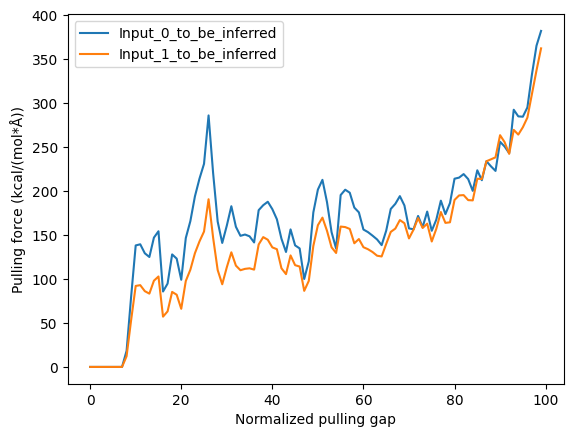

Now, make design based on the inputs...



Producing 2 samples...from image conditingig x_data  ...
Input contents:
cond_img condition: x_data=
 [array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        18.28863362,  80.0692019 , 138.13979123, 139.44611167,
       129.23179473, 124.99945748, 147.03594515, 154.26267409,
        85.748749  ,  94.74763505, 127.92603341, 123.13805332,
        99.12313939, 146.59346182, 165.770035  , 193.86780985,
       214.00913136, 230.90415894, 285.97514621, 220.28478982,
       165.21657777, 140.97041526, 160.604996  , 182.73803652,
       159.35024788, 149.0699255 , 150.54626136, 148.51384136,
       141.537062  , 178.25737158, 183.89341758, 187.809765  ,
       179.40302   , 167.89063924, 145.78564655, 130.70708892,
       156.36648317, 138.20652636, 134.73462406,  99.97278411,
       119.99524355, 175.66467083, 201.65559424, 212.72502818,
       187.39930591, 153.31598397, 

0it [00:00, ?it/s]

sampling time step:   0%|          | 0/96 [00:00<?, ?it/s]

result dim:  torch.Size([2, 1, 128])


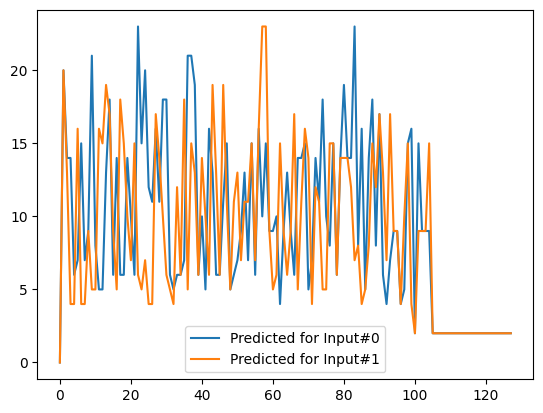

tensor([ 4, 20, 14, 14,  6,  7, 15,  7,  9, 21,  8,  5,  5, 13, 18,  6, 14,  6,
         6, 14, 10,  6, 23, 15, 20, 12, 11, 16, 11, 18, 18,  6,  5,  6,  6,  7,
        21, 21, 19,  6, 10,  5, 16, 13,  6,  6, 11, 15,  5,  6,  7,  9, 13,  7,
        15,  6, 16, 10, 15,  9,  9, 10,  4,  9, 13,  9,  6, 14, 14, 15,  5,  7,
        14, 11, 18, 10,  8, 15,  6, 14, 19, 14, 14, 23,  8, 16,  5, 14, 18,  8,
        17,  6,  4,  7,  9,  9,  4,  5, 15, 16,  4, 15,  9,  9,  9, 17, 20, 17,
        17, 11, 11,  4, 11, 17, 11, 11, 17, 11, 11, 11, 20, 17, 17, 17, 11,  4,
        11,  4], device='cuda:0')
tensor([20, 20, 13,  4,  4, 16,  4,  4,  9,  5,  5, 16, 15, 19, 17,  9,  5, 18,
        15, 10,  7, 15,  6,  5,  7,  4,  4, 17, 14, 10,  6,  5,  4, 12,  6, 18,
         5, 15, 13,  6, 14, 10,  6, 19, 13,  6, 19, 11,  5, 11, 13,  7, 11, 11,
        15,  7, 16, 23, 23,  9,  5,  6, 15,  9,  6,  9, 17,  5, 11, 16, 14,  4,
        12, 11,  5,  5, 15, 15,  6, 14, 14, 14, 12,  7,  8,  4,  5,  8, 15, 12,
      

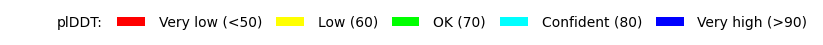

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

For None or [  0.           0.           0.           0.           0.
   0.           0.           0.          12.19242241  53.37946793
  92.09319415  92.96407444  86.15452982  83.33297166  98.02396343
 102.84178273  57.16583267  63.16509003  85.28402227  82.09203555
  66.08209293  97.72897455 110.51335667 129.24520657 142.67275424
 153.93610596 190.65009747 146.85652655 110.14438518  93.98027684
 113.26618295 130.32051743 115.21384005 109.95814935 111.50363362
 112.12047879 110.6379971  139.25401676 147.61078685 144.61681044
 135.93508952 133.8414882  112.20370803 105.51703962 126.78428185
 115.69128733 114.14739412  86.50069256  97.78519682 137.55264183
 161.15336059 169.76223629 154.79631037 136.03060112 129.56109911
 159.6066976  159.01942819 156.89666416 140.6024269  145.42806336
 136.13430188 133.84294094 130.63544912 126.44938608 125.60422528
 139.85916623 153.52631933 157.29334918 166.96625393 163.38836786
 146.11630993 156.10143063 169.23123586 157.99337498 162.88871136
 142.6

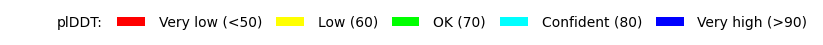

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
#@title ### Example:

#@markdown Infer for given unfolding force vecter


Sample_for_Num_inputs = 2 #@param {type:"slider", min:1, max:8, step:1}




#
if CKeys['Working_Mode']==2:
    if TestKeys['Sample_On_DeNovo']:
        #
        print("Run sampling on De Novo inputs set...")
        #
        # de novo test
        if CKeys['Problem_ID']==2 or CKeys['Problem_ID']==6 \
        or CKeys['Problem_ID']==11:
            print('Loading back a common de novo tests: ')
            import pickle
            pk_save_de_novo_list = this_working_path+'0_dataprocess_MD/ForTest_LE_128_From_F1_f5.pt'

            with open(pk_save_de_novo_list, 'rb') as handle:
                de_novo_test_condition_list = pickle.load(handle)

            de_novo_test_condition_list = de_novo_test_condition_list[:8]
            print("Get de novo tests #: ", len(de_novo_test_condition_list))
            # de_novo_test_condition_list = [
                # # =====================================
                # # sacle max:

                # UtilityPack.interpolate_and_resample_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*1.0,
                    # seq_len1=protein_df['seq_len'][pick_id_0],
                # )['y1'],  # max_forc x 1

                # UtilityPack.interpolate_and_resample_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*0.66,
                    # seq_len1=60,
                # )['y1'], # max_forc x 0.66

                # UtilityPack.interpolate_and_resample_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*0.33,
                    # seq_len1=60,
                # )['y1'], # max_forc x 0.33

                # UtilityPack.interpolate_and_resample_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*1.50,
                    # seq_len1=60,
                # )['y1'],  # max_forc x 1.5
            # # =====================================
            # # scale mid peak: 2

                # UtilityPack.interpolate_and_resample_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*1.0,
                    # seq_len1=protein_df['seq_len'][2],
                # )['y1'], # peak_mid x 1

                # UtilityPack.interpolate_and_resample_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*0.66,
                    # seq_len1=60,
                # )['y1'], # max_forc x 0.66

                # UtilityPack.interpolate_and_resample_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*0.33,
                    # seq_len1=60,
                # )['y1'],  # max_forc x 0.33

                # UtilityPack.interpolate_and_resample_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*1.50,
                    # seq_len1=60,
                # )['y1'],  # max_forc x 1.50
            # # ======================================
            # # mix two: max and min

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*1.,
                    # y1=protein_df['sample_FORCE_data'][pick_id_1]*0.,
                    # seq_len2=60,
                # )['y2'],  # max x 1 + min x 0

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*2./3.,
                    # y1=protein_df['sample_FORCE_data'][pick_id_1]*1./3.,
                    # seq_len2=60,
                # )['y2'],  # max x 2/3 + min x 1/3

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*1./2.,
                    # y1=protein_df['sample_FORCE_data'][pick_id_1]*1./2.,
                    # seq_len2=60,
                # )['y2'],  # max x 1/2 + min x 1/2

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*1./3.,
                    # y1=protein_df['sample_FORCE_data'][pick_id_1]*2./3.,
                    # seq_len2=60,
                # )['y2'],  # max x 1/3 + min x 2/3

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][pick_id_0]*0.,
                    # y1=protein_df['sample_FORCE_data'][pick_id_1]*1.,
                    # seq_len2=60,
                # )['y2'],  # max x 0. + min x 1.
            # # =======================================
            # # mix another two: middle peak 2 + slope 174

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*1.,
                    # y1=protein_df['sample_FORCE_data'][174]*0.,
                    # seq_len2=60,
                # )['y2'], # max x 1 + min x 0

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*2./3.,
                    # y1=protein_df['sample_FORCE_data'][174]*1./3.,
                    # seq_len2=60,
                # )['y2'],  # max x 2/3 + min x 1/3

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*1./2.,
                    # y1=protein_df['sample_FORCE_data'][174]*1./2.,
                    # seq_len2=60,
                # )['y2'],  # max x 1/2 + min x 1/2

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*1./3.,
                    # y1=protein_df['sample_FORCE_data'][174]*2./3.,
                    # seq_len2=60,
                # )['y2'], # max x 1/3 + min x 2/3

                # UtilityPack.mix_two_ForcPath(
                    # y0=protein_df['sample_FORCE_data'][2]*0.,
                    # y1=protein_df['sample_FORCE_data'][174]*1.,
                    # seq_len2=60,
                # )['y2'],  # max x 0. + min x 1.

            # ]

        elif CKeys['Problem_ID']==3:
            de_novo_test_condition_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0, 0.7, 0.07, 0.1, 0.01, 0.02, 0.01, 0.11],
            ]
        elif CKeys['Problem_ID']==4:
            # normalized (Fmax,Toughness)
            de_novo_test_condition_list = [
                [0.8, 0.8],
                [0.8, 0.2],
            ]

        elif CKeys['Problem_ID']==5:
            de_novo_test_condition_list = [
                ['~~~HHHHHHHHHHHHHHH~~'],
                ['~~EEESSTTS~SEEEEEEEEE~SBS~EEEEEE~~'],
            ]





if CKeys['Working_Mode']==2:
    #
    if TestKeys['Sample_On_DeNovo']:


        if CKeys['Problem_ID']==2:
            TrainerPack.sample_sequence_omegafold_ModelB (
                working_model_B,
                x_data=NewInput_List,
                flag=last_epoch, # flag="DeNovo", # ,
                cond_scales=1.,
                foldproteins=True, # foldproteins,
                # ++++++++++
                ynormfac=DataKeys['ynormfac'],
                train_unet_number=1, # train_unet_number,
                tokenizer_X=tokenizer_X,
                Xnormfac=DataKeys['Xnormfac'],
                max_length=DataKeys['max_AA_seq_len'], # max_length,
                prefix=PKeys['prefix'], # prefix,
                tokenizer_y=tokenizer_y,
                # ++
                CKeys=CKeys,
                sample_dir=TestKeys['test_dir'], # sample_dir,
                steps=last_step,
                e=last_epoch,
                IF_showfig= True, # CKeys['SlientRun']!=1,
            )

        elif CKeys['Problem_ID']==3:
            TrainerPack.sample_sequence_omegafold_ModelA (
                # # ----------------------------------------------
                # model,
                # X=[[0, 0.7, 0.07, 0.1, 0.01, 0.02, 0.01, 0.11]],
                # foldproteins=foldproteins,
                # flag=steps,cond_scales=1.,
                # ++++++++++++++++++++++++++++++++++++++++++++++
                working_model,
                X=test_condition_list, # [[0.92, 0., 0.04, 0.04, 0., 0., 0., 0., ]], # from text conditioning X
                flag=last_epoch, # e+start_ep, # steps, # 0,
                cond_scales=1., # cond_scales, # 1.,
                foldproteins=True, # False,
                X_string=None,                                # from text conditioning X_string
                x_data=None,                                  # from image conditioning x_data
                skip_steps=0,
                inpaint_images=None, # in formation Y data
                inpaint_masks = None,
                inpaint_resample_times = None,
                init_images = None,
                num_cycle=16,          # for omegafolding
                calc_error=True, # False,      # for check on folded results, not used for every case
                # ++++++++++++++++++++++++++
                # tokenizers
                tokenizer_X_forImageCondi=None, # for x_data
                Xnormfac_forImageCondi=1.,
                tokenizer_X_forTextCondi=None,  # for X if NEEDED only
                Xnormfac_forTextCondi=DataKeys['Xnormfac'], # 1.,
                tokenizer_y=tokenizer_y, # None, # for output Y
                ynormfac=DataKeys['ynormfac'], # ynormfac,
                # length
                train_unet_number=1,
                max_length_Y=DataKeys['max_AA_seq_len'], # max_length_Y,                 # for Y, X_forImageCondi
                max_text_len=DataKeys['max_text_len'], # max_text_len_X,                 # for    X_forTextCondi
                # other info
                steps=last_step, # steps, # None,
                e=last_epoch, # e, # None,
                sample_dir=TestKeys['test_dir'], # sample_dir, # None,
                prefix=PKeys['prefix'], # prefix, # None,
                IF_showfig= True, # CKeys['SlientRun']!=1, # True,
                CKeys=CKeys,
                # TBA to Model B
                normalize_X_cond_to_one=False,
            )
        #
        elif CKeys['Problem_ID']==4:
            TrainerPack.sample_sequence_omegafold_ModelA (
                # # ----------------------------------------------
                # model,
                # X=[[0, 0.7, 0.07, 0.1, 0.01, 0.02, 0.01, 0.11]],
                # foldproteins=foldproteins,
                # flag=steps,cond_scales=1.,
                # ++++++++++++++++++++++++++++++++++++++++++++++
                working_model,
                X=test_condition_list, # [[0.92, 0., 0.04, 0.04, 0., 0., 0., 0., ]], # from text conditioning X
                flag=last_epoch, # e+start_ep, # steps, # 0,
                cond_scales=1., # cond_scales, # 1.,
                foldproteins=True, # False,
                X_string=None,                                # from text conditioning X_string
                x_data=None,                                  # from image conditioning x_data
                skip_steps=0,
                inpaint_images=None, # in formation Y data
                inpaint_masks = None,
                inpaint_resample_times = None,
                init_images = None,
                num_cycle=16,          # for omegafolding
                # only for ModelA-SecStr:ProblemID:4
                calc_error=False, # True, # False,      # for check on folded results, not used for every case
                # ++++++++++++++++++++++++++
                # tokenizers
                tokenizer_X_forImageCondi=None, # for x_data
                Xnormfac_forImageCondi=1.,
                tokenizer_X_forTextCondi=None,  # for X if NEEDED only
                Xnormfac_forTextCondi=DataKeys['Xnormfac'], # 1.,
                tokenizer_y=tokenizer_y, # None, # for output Y
                ynormfac=DataKeys['ynormfac'], # ynormfac,
                # length
                train_unet_number=1,
                max_length_Y=DataKeys['max_AA_seq_len'], # max_length_Y,                 # for Y, X_forImageCondi
                max_text_len=DataKeys['max_text_len'], # max_text_len_X,                 # for    X_forTextCondi
                # other info
                steps=last_step, # steps, # None,
                e=last_epoch, # e, # None,
                sample_dir=TestKeys['test_dir'], # sample_dir, # None,
                prefix=PKeys['prefix'], # prefix, # None,
                IF_showfig= True, # CKeys['SlientRun']!=1, # True,
                CKeys=CKeys,
                # TBA to Model B
                normalize_X_cond_to_one=False,
            )
        # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        # Model B + SecStr
        # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        elif CKeys['Problem_ID']==5:
            DeNovoSam_pdbs, DeNovoSam_fasta = \
            TrainerPack.sample_sequence_omegafold_pLM_ModelB (
                working_model,
                x_data=NewInput_List,
                flag=last_epoch, # flag="DeNovo", # ,
                cond_scales=1.,
                foldproteins=True, # foldproteins,
                # ++++++++++
                ynormfac=DataKeys['ynormfac'],
                train_unet_number=1, # train_unet_number,
                tokenizer_X=tokenizer_X,
                Xnormfac=DataKeys['Xnormfac'],
                max_length=DataKeys['max_AA_seq_len'], # max_length,
                prefix=PKeys['prefix'], # prefix,
                tokenizer_y=tokenizer_y,
                # ++
                CKeys=CKeys,
                sample_dir=TestKeys['test_dir'], # sample_dir,
                steps=last_step,
                e=last_epoch,
                IF_showfig= True, # CKeys['SlientRun']!=1,
                # ++
                pLM_Model=pLM_Model,
                pLM_Model_Name=pLM_Model_Name,
                image_channels=DataKeys['image_channels'],
                pLM_alphabet=esm_alphabet,
            )
        #
        elif CKeys['Problem_ID']==6:
            DeNovoSam_pdbs, DeNovoSam_fasta = \
            TrainerPack.sample_sequence_omegafold_pLM_ModelB_For_ForcPath (
                working_model,
                x_data=de_novo_test_condition_list[:2],
                flag=last_epoch, # flag="DeNovo", # ,
                cond_scales=[1., 2.],
                foldproteins=True, # foldproteins,
                # ++++++++++
                ynormfac=DataKeys['ynormfac'],
                train_unet_number=1, # train_unet_number,
                tokenizer_X=tokenizer_X,
                Xnormfac=DataKeys['Xnormfac'],
                max_length=DataKeys['max_AA_seq_len'], # max_length,
                prefix=PKeys['prefix'], # prefix,
                tokenizer_y=tokenizer_y,
                # ++
                CKeys=CKeys,
                sample_dir=TestKeys['test_dir'], # sample_dir,
                steps=last_step,
                e=last_epoch,
                IF_showfig= True, # CKeys['SlientRun']!=1,
                # ++
                pLM_Model=pLM_Model,
                pLM_Model_Name=pLM_Model_Name,
                image_channels=DataKeys['image_channels'],
                pLM_alphabet=esm_alphabet,
            )

            # DeNovoSam_pdbs, DeNovoSam_fasta = \
            # TrainerPack.sample_sequence_omegafold_pLM_ModelB (
            #     working_model,
            #     x_data=NewInput_List,
            #     flag=last_epoch, # flag="DeNovo", # ,
            #     cond_scales=1.,
            #     foldproteins=True, # foldproteins,
            #     # ++++++++++
            #     ynormfac=DataKeys['ynormfac'],
            #     train_unet_number=1, # train_unet_number,
            #     tokenizer_X=tokenizer_X,
            #     Xnormfac=DataKeys['Xnormfac'],
            #     max_length=DataKeys['max_AA_seq_len'], # max_length,
            #     prefix=PKeys['prefix'], # prefix,
            #     tokenizer_y=tokenizer_y,
            #     # ++
            #     CKeys=CKeys,
            #     sample_dir=TestKeys['test_dir'], # sample_dir,
            #     steps=last_step,
            #     e=last_epoch,
            #     IF_showfig= True, # CKeys['SlientRun']!=1,
            #     # ++
            #     pLM_Model=pLM_Model,
            #     pLM_Model_Name=pLM_Model_Name,
            #     image_channels=DataKeys['image_channels'],
            #     pLM_alphabet=esm_alphabet,
            # )
        #
        elif CKeys['Problem_ID']==7:
            DeNovoSam_pdbs, fasta_file_list=\
            TrainerPack.sample_sequence_omegafold_pLM_ModelA (
                working_model,
                X=NewInput_List, # test_condition_list, # [[0.92, 0., 0.04, 0.04, 0., 0., 0., 0., ]], # from text conditioning X
                flag=last_epoch, # e+start_ep, # steps, # 0,
                cond_scales=1.,
                foldproteins=True, # False,
                X_string=None,                                # from text conditioning X_string
                x_data=None,                                  # from image conditioning x_data
                skip_steps=0,
                inpaint_images=None, # in formation Y data
                inpaint_masks = None,
                inpaint_resample_times = None,
                init_images = None,
                num_cycle=16,          # for omegafolding
                calc_error=True, # False,      # for check on folded results, not used for every case
                # ++++++++++++++++++++++++++
                # tokenizers
                tokenizer_X_forImageCondi=None, # for x_data
                Xnormfac_forImageCondi=1.,
                tokenizer_X_forTextCondi=None,  # for X if NEEDED only
                Xnormfac_forTextCondi=1.,
                tokenizer_y=tokenizer_y, # None, # for output Y
                ynormfac=DataKeys['ynormfac'], # ynormfac,
                # length
                train_unet_number=1,
                max_length_Y=DataKeys['max_AA_seq_len'], # max_length_Y,                 # for Y, X_forImageCondi
                max_text_len=DataKeys['max_text_len'], # max_text_len_X,                 # for    X_forTextCondi
                # other info
                steps=last_step, # None,
                e=last_epoch, # None,
                sample_dir=TestKeys['test_dir'], # None,
                prefix=PKeys['prefix'], # None,
                IF_showfig= True, # CKeys['SlientRun']!=1, # True,
                CKeys=CKeys,
                # TBA to Model B
                normalize_X_cond_to_one=False,
                # ++ for pLM
                pLM_Model=pLM_Model,
                pLM_Model_Name=pLM_Model_Name,
                image_channels=DataKeys['image_channels'], # image_channels,
                pLM_alphabet=esm_alphabet,
            )

        elif CKeys['Problem_ID']==8:
            DeNovoSam_pdbs, fasta_file_list=\
            TrainerPack.sample_sequence_omegafold_pLM_ModelA (
                working_model,
                X=NewInput_List, # test_condition_list, # [[0.92, 0., 0.04, 0.04, 0., 0., 0., 0., ]], # from text conditioning X
                flag=last_epoch, # e+start_ep, # steps, # 0,
                cond_scales=1.,
                foldproteins=True, # False,
                X_string=None,                                # from text conditioning X_string
                x_data=None,                                  # from image conditioning x_data
                skip_steps=0,
                inpaint_images=None, # in formation Y data
                inpaint_masks = None,
                inpaint_resample_times = None,
                init_images = None,
                num_cycle=16,          # for omegafolding
                calc_error=True, # False,      # for check on folded results, not used for every case
                # ++++++++++++++++++++++++++
                # tokenizers
                tokenizer_X_forImageCondi=None, # for x_data
                Xnormfac_forImageCondi=1.,
                tokenizer_X_forTextCondi=None,  # for X if NEEDED only
                Xnormfac_forTextCondi=1.,
                tokenizer_y=tokenizer_y, # None, # for output Y
                ynormfac=DataKeys['ynormfac'], # ynormfac,
                # length
                train_unet_number=1,
                max_length_Y=DataKeys['max_AA_seq_len'], # max_length_Y,                 # for Y, X_forImageCondi
                max_text_len=DataKeys['max_text_len'], # max_text_len_X,                 # for    X_forTextCondi
                # other info
                steps=last_step, # None,
                e=last_epoch, # None,
                sample_dir=TestKeys['test_dir'], # None,
                prefix=PKeys['prefix'], # None,
                IF_showfig= CKeys['SlientRun']!=1, # True,
                CKeys=CKeys,
                # TBA to Model B
                normalize_X_cond_to_one=False,
                # ++ for pLM
                pLM_Model=pLM_Model,
                pLM_Model_Name=pLM_Model_Name,
                image_channels=DataKeys['image_channels'], # image_channels,
                pLM_alphabet=esm_alphabet,
            )

        elif CKeys['Problem_ID']==11:
            # plot the input
            print("On the inputs:")
            fig = plt.figure(figsize=(24,16),dpi=200)
            fig, ax0 = plt.subplots()
            for ii in range(Sample_for_Num_inputs):
              ax0.plot(
                  de_novo_test_condition_list[ii],
                  label='Input_'+str(ii+0)+'_to_be_inferred'
                  )

            plt.legend()
            plt.xlabel('Normalized pulling gap')
            plt.ylabel('Pulling force (kcal/(mol*Å))')
            plt.show()
            plt.close()
            # conduct inferring
            print("Now, make design based on the inputs...")
            print("\n\n")
            DeNovoSam_pdbs, DeNovoSam_fasta = \
            TrainerPack.sample_sequence_omegafold_pLM_ModelB_For_ForcPath (
                working_model,
                x_data=de_novo_test_condition_list[:Sample_for_Num_inputs], # [:2],
                flag=100, #last_epoch, # flag="DeNovo", # ,
                cond_scales=[1.],
                foldproteins=True, # foldproteins,
                # ++++++++++
                ynormfac=DataKeys['ynormfac'],
                train_unet_number=1, # train_unet_number,
                tokenizer_X=tokenizer_X,
                Xnormfac=DataKeys['Xnormfac'],
                max_length=DataKeys['max_AA_seq_len'], # max_length,
                prefix=PKeys['prefix'], # prefix,
                tokenizer_y=tokenizer_y,
                # ++
                CKeys=CKeys,
                sample_dir=TestKeys['test_dir'], # sample_dir,
                steps=100, # last_step,
                e=100, # last_epoch,
                IF_showfig= True, # CKeys['SlientRun']!=1,
                # ++
                pLM_Model=pLM_Model,
                pLM_Model_Name=pLM_Model_Name,
                image_channels=DataKeys['image_channels'],
                pLM_alphabet=esm_alphabet,
            )

